In [1]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime,date
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
plt.style.use('seaborn-darkgrid')
from math import fsum
#from varname import nameof
from scipy import stats
from scipy.stats import pearsonr,spearmanr
import os
import myfunctions as mf
from importlib import reload
from pandas.api.types import is_numeric_dtype
import warnings
warnings.filterwarnings('ignore')
import random

#Define some lists/arrays

#https://escomp.github.io/ctsm-docs/versions/release-clm5.0/html/tech_note/Ecosystem/CLM50_Tech_Note_Ecosystem.html#id17
depth  = np.array([0.02, 0.04, 0.06, 0.08,0.12,0.16,0.20,0.24,0.28,0.32,0.36,0.40,0.44,0.54,0.64,0.74,0.84,0.94,1.04,1.14,2.39,4.676,7.635,11.140,15.115]) #layer thicknesses
node_z = [0.01,0.04,0.09,0.16,0.26,0.40,0.587,0.80,1.06,1.36,1.70,2.08,2.50,2.99,3.58,4.27,5.06,5.95,6.94,8.03,9.795,13.328,19.483,28.871,41.998] #depth of midpoint of layers
depth_30 = np.array([0.02,0.04,0.06,0.08,0.10]) #layer depths to multiply with concentrations
depth_50 = np.array([0.02,0.04,0.06,0.08,0.12,0.16,0.02]) #[meters]

sec_pr_day = 60*60*24

C_pool_names = ['LITm', 'LITs', 'SAPb', 'SAPf', 'EcM','AM', 'SOMp', 'SOMa', 'SOMc'] 
N_pool_names = ['N_LITm', 'N_LITs', 'N_SAPb', 'N_SAPf', 'N_EcM', 'N_AM','N_SOMp', 'N_SOMa', 'N_SOMc', 'N_NH4_sol','N_NH4_sorp','N_NO3']

PFT_names = ["not_vegetated                           ",
    "needleleaf_evergreen_temperate_tree     ",
    "needleleaf_evergreen_boreal_tree        ",
    "needleleaf_deciduous_boreal_tree        ",
    "broadleaf_evergreen_tropical_tree       ",
    "broadleaf_evergreen_temperate_tree      ",
    "broadleaf_deciduous_tropical_tree       ",
    "broadleaf_deciduous_temperate_tree      ",
    "broadleaf_deciduous_boreal_tree         ",
    "broadleaf_evergreen_shrub               ",
    "broadleaf_deciduous_temperate_shrub     ",
    "broadleaf_deciduous_boreal_shrub        ",
    "c3_arctic_grass                         ",
    "c3_non-arctic_grass                     ",
    "c4_grass                                ",]

PFT_names=[i.strip() for i in PFT_names]

temp_colors = ["blue","red"]
prec_colors = ["goldenrod","lightseagreen"]

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

obs_cols = ['CLFH', 'C30', 'cstock', 'c100min','LFHDYP', 'PROFDYPC', 'NLFH', 'nstock',  'n100min','ALTITUDE','PBONITET', 'VEKSTSES', 'DRAINAGE',"MAP","MAT"]
pod_cols = ['CLFH', 'C30', 'cstock', 'c100min','LFHDYP', 'PROFDYPC', 'NLFH', 'nstock',  'n100min','ALTITUDE','PBONITET', 'VEKSTSES', 'DRAINAGE',"MAP","MAT"]
dec_cols = ['TOTC', 'TOTC_input', 'HR_flux', 'c30_SOM_tot', 'c30_tot','depth','SAP', 'MYC', 'FBratio','pct_microbes', 'TOTLITC', 'TOTSOMC', 'TOTN', 'TOTLITN', 'TOTSOMN','NH4_sol', 'NH4_sorp', 'NO3']
CLM_cols = ['TOTSOMC', 'TOTSOMN', 'TOTLITC','TOTLITN', 'HR', 'NPP', 'LITFALL', 'n_bedrock', 'c30_tot', 'TOTN', 'TOTC',"MAT","MAP"]

pd.set_option('display.max_columns', 500)

### Import data

In [2]:
def get_observations(list_of_site_numbers):

    df = pd.read_excel("/home/ecaas/Desktop/jordprofiler/CNstocks2016_HAdW_updated_LTS9august21.xlsx", sheet_name="Sheet1") #Get data
    komm = pd.read_excel("/home/ecaas/Desktop/jordprofiler/Kommuneklassifisering_1994.xlsx", sheet_name="Sheet1") #Get Kommunenavn
    all_sites = df[1:]  # All lines containing values (all but first line)
    info = df.iloc[0]  # First line contains more info

    # Change dtype to approproate types
    for c in all_sites.columns:
        if all_sites.loc[:, c].dtype == object:
            if type(all_sites.loc[:, c].iloc[0]) != str:
                all_sites.loc[:, c] = pd.to_numeric(all_sites.loc[:, c])
            else:
                all_sites.loc[:, c] = all_sites.loc[:, c].astype('category')

    # Add kommune (county) as a column to the data frame "all_sites"
    kommune = []
    for knr in all_sites.KOMM:
        if knr not in komm.loc[:, 'Kommune-nr.'].values:
            kommune.append('NO MATCH')
        else:
            for snr in komm.loc[:, 'Kommune-nr.']:
                if knr == snr:
                    kommune.append(
                        komm[komm['Kommune-nr.'] == snr]['Kommunenavn'].values[0])
    all_sites.loc[:, 'Kommunenavn'] = kommune

    # Chosen locations for decomp development 
    sites = list_of_site_numbers
    sites_df = all_sites.loc[all_sites['PROFNR'].isin(sites)].reset_index()

    for i in range(len(sites_df)):
        site = ('NR'+str(sites_df.loc[i, 'PROFNR']) + '_'+sites_df.loc[i, 'Kommunenavn']).strip()
        sites_df.loc[i, 'SITE'] = site
        obs = sites_df.loc[:, ['SITE','PROFNR', 'CLFH', 'C30', 'C50', 'cs100', 'cstock', 'c100min', 'COMratio', 'LFHDYP', 'PROFDYPC', 'NLFH', 'nstock', 'ns100', 'n100min', 'NOMratio', 'CNFOREST', 'KOORDINA','MAP', 'MAT', 'TREG', 'VEGETASJ', 'ALTITUDE', 'PBONITET', 'VEKSTSES', 'DRAINAGE', 'FAOTex', 'CanTex', "CANADIAN", "VEGTYP", "FID", "BEST_TRE"]].sort_values(by='SITE')

    obs.loc[:, "origin"] = "obs"

    for col in obs[['LFHDYP', 'PROFDYPC']].columns:  # convert observed depths to meters
        obs.loc[:, col] = obs.loc[:, col]/100.0

    for col in obs[['cstock', 'nstock', 'C50', 'C30', 'MAP', 'MAT', "cs100", "ns100", "c100min", "n100min", "CLFH", "NLFH"]].columns:  # Round to two decimals
        obs.loc[:, col] = round(obs.loc[:, col], 2)

    english_var_names={"VEKSTSES":"growing_season","PROFDYPC":"tot_depth","LFHDYP":"depth_LFH_layer","PBONITET":"quality_class"}
    obs.rename(columns = english_var_names,inplace=True)
    return obs, info

In [3]:
#Create dataframe containing OBS data
chosen_sites=['32258','32246' ,'31984','31976','32379','32441','32032','32124','32288','31463','31464','32087','31652','31881','32182','32249','32485','31682','31578','32361',\
        '31585','32085','31714','31650','31519','32438','32409','32404','32374','32139','32103','32088','31997',\
        '31513','31539','31767','31780','31941','31906','31927','31461','32174','32173','32170','31883','31801','31799','31579','31577','31677']
obs_subset, info = get_observations(chosen_sites)

#Replace Norwegian letters
obs_subset.replace(to_replace="NR32258_Målselv",value="NR32258_Maaselv",inplace =True)
obs_subset.replace(to_replace="NR32085_Skjåk",value="NR32085_Skjaak",inplace =True)
obs_subset.replace(to_replace="NR31780_Våler",value="NR31780_Vaaler",inplace =True)
obs_subset.replace(to_replace="NR31714_Flå",value="NR31714_Flaa",inplace =True)
obs_subset.replace(to_replace="NR31941_Røyrvik",value="NR31941_Roeyrvik",inplace =True)
obs_subset.replace(to_replace="NR31682_Tysvær",value="NR31682_Tysvar",inplace =True)
obs_subset.replace(to_replace="NR32032_Vestre  Toten",value="NR32032_VestreToten",inplace =True)
obs_subset.replace(to_replace="NR32246_Sør-Varanger",value="NR32246_SoerVaranger",inplace =True)

obs_subset.head()

,SITE,PROFNR,CLFH,C30,C50,cs100,cstock,c100min,COMratio,depth_LFH_layer,tot_depth,NLFH,nstock,ns100,n100min,NOMratio,CNFOREST,KOORDINA,MAP,MAT,TREG,VEGETASJ,ALTITUDE,quality_class,growing_season,DRAINAGE,FAOTex,CanTex,CANADIAN,VEGTYP,FID,BEST_TRE,origin
0,NR31461_Nittedal,31461,2.02,4.19,4.27,4.27,4.27,2.26,52.784161,0.05,0.49,0.07,0.14,0.14,0.07,48.937772,28.0,238500.0,939.0,2.71,Spruce,Blåbærskog,338,14.0,158.0,7.0,Medium,Loamy,Podzol,A4AT,C15016,1.0,obs
1,NR31463_Hurdal,31463,5.44,16.49,19.67,19.67,19.67,14.22,72.317986,0.08,0.43,0.27,1.00,1.00,0.73,73.318498,20.0,265500.0,879.0,3.47,Spruce,Blåbærskog,378,14.0,171.0,10.0,Coarse,Loamy,Podzol,A5AT,C15176,1.0,obs
2,NR31464_Hurdal,31464,1.84,6.22,8.77,9.38,9.38,7.54,80.391512,0.04,0.65,0.08,0.51,0.51,0.43,83.461581,22.0,274500.0,870.1,2.98,Spruce,Lågurtskog,423,17.0,168.0,4.0,Medium,Loamy,Podzol,A5AT,C15226,1.0,obs
3,NR31513_Nes,31513,7.85,16.82,23.60,30.90,30.90,23.05,74.602138,0.09,0.90,0.18,0.99,0.99,0.81,81.947020,44.0,229500.0,747.1,3.21,Spruce,Blåbærskog,240,14.0,167.0,8.0,Coarse,Loamy,Podzol,A4AV,C12216,1.0,obs
4,NR31519_Nissedal,31519,8.71,14.42,17.53,20.23,20.23,11.52,56.929197,0.14,0.74,0.29,0.68,0.68,0.39,57.572803,30.0,112500.0,1017.1,4.18,Pine,Bærlyngskog,350,8.0,170.0,10.0,Coarse,Loamy,Podzoli,A2AR,B11125,4.0,obs


In [4]:
#create a dataframe containing all podzolic sites in the database:
df = pd.read_excel("/home/ecaas/Desktop/jordprofiler/CNstocks2016_HAdW_updated_LTS9august21.xlsx", sheet_name="Sheet1")
alle = df[1:]
all_sites = alle.PROFNR.values

all_obs,info_all = mf.get_observations(list(all_sites))
all_obs = all_obs.sort_values(by="SITE")

pod1= all_obs[all_obs.CANADIAN == "Podzol"]
pod2 = all_obs[all_obs.CANADIAN == "Podzoli"]

podzols = pod1.append(pod2)

del pod1,pod2,alle,df,info_all 


#### Load CLM data

In [5]:
#Import CLM results into xarrays
path='/home/ecaas/Documents/all_1988-1992/'
directory = os.fsencode(path)
CLM_xarray=[]
for file in os.listdir(directory):
    filename = os.fsdecode(file) 
    name = filename[:-22]
    if name[0:2] != 'NR':
        name='NR'+name+'_CLM'
    else:
        name=name+'_CLM' 
    globals()[name] = xr.load_dataset(path+filename)
    globals()[name].attrs['site_name'] = name[:-4]
    CLM_xarray.append(globals()[name])

CLM_xarray =  sorted(CLM_xarray,key=lambda x: x.site_name)


In [6]:
def make_CLM_df(xarray_list):

    column_names = ['SITE','RAIN', 'SNOW', 'TSA', 'TOTSOMC','TOTSOMN', 'TOTLITC', 'TOTLITN']
    mean_df = pd.DataFrame(columns=column_names)
    mean_df['MAP'] = np.nan
    hr = []
    mean_df["SITE"] = (mean_df.SITE).astype("category")

    # layer depths to multiply with concentrations
    depth_30 = np.array([0.02, 0.04, 0.06, 0.08, 0.10])
    depth_50 = np.array([0.02, 0.04, 0.06, 0.08, 0.12, 0.16, 0.02])  # [meters]
    sec_pr_day = 60*60*24

    for i in range(len(xarray_list)):  # loop through all xarrays (one for each site)
        val = xarray_list[i][['RAIN', 'SNOW', 'TSA', 'TOTSOMC','TOTSOMN', 'TOTLITC', 'TOTLITN', "HR", "NPP", "LITFALL"]]
        # mean over total time period for the vars in the line above
        val = val.mean(dim="time")
        # convert from xarray to pd dataframe (row)
        val = val.to_dataframe().reset_index(drop=True)
        # add site name to val (which is a dataframe row)
        val['SITE'] = [xarray_list[i].site_name]
        # add row to main dataframe
        mean_df = mean_df.append(val, ignore_index=True)

        col = xarray_list[i][['SOIL1C_vr', 'SOIL2C_vr','SOIL3C_vr', 'LITR1C_vr', 'LITR2C_vr', 'LITR3C_vr']]
        col = col.mean(dim="time")  # Mean concentration for each layer
        col = col.to_dataframe().reset_index(drop=True)

        # get correct row in dataframe mean_df
        t = mean_df.loc[mean_df['SITE'] == xarray_list[i].site_name]

        for var in col.columns:  # loop variables
            # multiply with relevant depths to get mass (gC/m2)
            col30 = col[var][0:len(depth_30)]*depth_30
            col50 = col[var][0:len(depth_50)]*depth_50
            sum30 = col30.sum()  # Sum of mass in the relevant layers
            sum50 = col50.sum()
            mean_df.loc[t.index, 'c50_%s' % var[0:5]] = round(
                sum50, 2)  # add to the row where site name matches
            mean_df.loc[t.index, 'c30_%s' % var[0:5]] = round(sum30, 2)

        ##########Nitrogen#######################
        colN = xarray_list[i][['SOIL1N_vr', 'SOIL2N_vr','SOIL3N_vr', 'LITR1N_vr', 'LITR2N_vr', 'LITR3N_vr']]
        colN = colN.mean(dim="time")  # Mean concentration for each layer
        colN = colN.to_dataframe().reset_index(drop=True)

        # get correct row in dataframe mean_df
        t = mean_df.loc[mean_df['SITE'] == xarray_list[i].site_name]

        for var in colN.columns:  # loop variables
            # multiply with relevant depths to get mass (gC/m2)
            colN30 = colN[var][0:len(depth_30)]*depth_30
            colN50 = colN[var][0:len(depth_50)]*depth_50
            sum30 = colN30.sum()  # Sum of mass in the relevant layers
            sum50 = colN50.sum()
            mean_df.loc[t.index, 'n50_%s' % var[0:5]] = round(
                sum50, 4)  # add to the row where site name matches
            mean_df.loc[t.index, 'n30_%s' % var[0:5]] = round(sum30, 4)
            ################################


        # Put shallowest bedrock layer (nbedrock) in dataframe mean_df
        nbedrock = xarray_list[i].nbedrock.values
        mean_df.loc[t.index, 'n_bedrock'] = nbedrock

        # Put mean annual precipitation from simulations in mean_df
        # Add RAIN and SNOW to get total precip
        daily_precip = (xarray_list[i].SNOW + xarray_list[i].RAIN)*sec_pr_day
        # Find annual precip for each year
        yearly_precip = daily_precip.groupby('time.year').sum()
        # Find mean annual precip for the years 1988-1992 (drop 1993)
        precip = yearly_precip[:-1].mean().values
        mean_df.loc[t.index, 'MAP'] = round(float(precip), 1)

        ###########Carbon############################
        sum_soil50 = mean_df.loc[t.index, 'c50_SOIL1'] + mean_df.loc[t.index, 'c50_SOIL2'] + mean_df.loc[t.index, 'c50_SOIL3']
        mean_df.loc[t.index, 'c50_SOIL_tot'] = sum_soil50

        sum_soil30 = mean_df.loc[t.index, 'c30_SOIL1'] + mean_df.loc[t.index, 'c30_SOIL2']+mean_df.loc[t.index, 'c30_SOIL3']
        mean_df.loc[t.index, 'c30_SOIL_tot'] = sum_soil30

        sum_tot50 = mean_df.loc[t.index, 'c50_SOIL1']+mean_df.loc[t.index, 'c50_SOIL2']+mean_df.loc[t.index, 'c50_SOIL3'] + \
                    mean_df.loc[t.index, 'c50_LITR1']+mean_df.loc[t.index,'c50_LITR2']+mean_df.loc[t.index, 'c50_LITR3']
        mean_df.loc[t.index, 'c50_tot'] = sum_tot50

        sum_tot30 = mean_df.loc[t.index, 'c30_SOIL1']+mean_df.loc[t.index, 'c30_SOIL2']+mean_df.loc[t.index, 'c30_SOIL3'] + \
                    mean_df.loc[t.index, 'c30_LITR1']+mean_df.loc[t.index,'c30_LITR2']+mean_df.loc[t.index, 'c30_LITR3']
        mean_df.loc[t.index, 'c30_tot'] = sum_tot30

        ###########Nitrogen############################
        sumN_soil50 = mean_df.loc[t.index, 'n50_SOIL1'] + \
            mean_df.loc[t.index, 'n50_SOIL2']+mean_df.loc[t.index, 'n50_SOIL3']
        mean_df.loc[t.index, 'n50_SOIL_tot'] = sumN_soil50

        sumN_soil30 = mean_df.loc[t.index, 'n30_SOIL1'] + \
            mean_df.loc[t.index, 'n30_SOIL2']+mean_df.loc[t.index, 'n30_SOIL3']
        mean_df.loc[t.index, 'n30_SOIL_tot'] = sumN_soil30

        sumN_tot50 = mean_df.loc[t.index, 'n50_SOIL1']+mean_df.loc[t.index, 'n50_SOIL2']+mean_df.loc[t.index, 'n50_SOIL3'] + \
            mean_df.loc[t.index, 'n50_LITR1']+mean_df.loc[t.index,
                                                          'n50_LITR2']+mean_df.loc[t.index, 'n50_LITR3']
        mean_df.loc[t.index, 'n50_tot'] = sumN_tot50

        sumN_tot30 = mean_df.loc[t.index, 'n30_SOIL1']+mean_df.loc[t.index, 'n30_SOIL2']+mean_df.loc[t.index, 'n30_SOIL3'] + \
            mean_df.loc[t.index, 'n30_LITR1']+mean_df.loc[t.index,
                                                          'n30_LITR2']+mean_df.loc[t.index, 'n30_LITR3']
        mean_df.loc[t.index, 'n30_tot'] = sumN_tot30
        #############################


    mean_df.loc[:, "origin"] = "CLM"

    # convert mean_df temperature to celsius
    mean_df.loc[:, "TSA_degC"] = round(mean_df.TSA-273.15, 1)

    mean_df["TOTN"] = mean_df.TOTSOMN+mean_df.TOTLITN
    mean_df["TOTC"] = mean_df.TOTSOMC+mean_df.TOTLITC
    mean_df["HR"]  = mean_df.HR*60*60 

    for col in mean_df[['TOTSOMC', 'TOTSOMN', 'TOTLITC', 'c50_tot', 'c30_tot', 'TOTC', 'TOTN',
                        'c50_SOIL1', 'c30_SOIL1', 'c50_SOIL2', 'c30_SOIL2', 'c50_SOIL3', 'c30_SOIL3',
                        'c50_LITR1', 'c30_LITR1', 'c50_LITR2', 'c30_LITR2', 'c50_LITR3', 'c30_LITR3', 
                        'c50_SOIL_tot', 'c30_SOIL_tot',]].columns:  # convert mean_df content to kg/m2
        mean_df.loc[:, col] = round(mean_df.loc[:, col]*1e-3, 2)

    for col in mean_df[['n50_SOIL_tot','n30_SOIL_tot','n50_tot','n30_tot']].columns:
        mean_df.loc[:,col]=round(mean_df.loc[:, col]*1e-3, 4)

    mean_df.loc[:, "TOTLITN"] = round(mean_df.loc[:, "TOTLITN"]*1e-3, 4)

    mean_df = mean_df.sort_values(by="SITE")
    mean_df.reset_index(inplace=True)
    mean_tmp = mean_df[['c50_SOIL1', 'c30_SOIL1', 'c50_SOIL2', 'c30_SOIL2', 'c50_SOIL3', 'c30_SOIL3', 'c50_LITR1',
                        'c30_LITR1', 'c50_LITR2', 'c30_LITR2', 'c50_LITR3', 'c30_LITR3', 'c50_SOIL_tot', 'c30_SOIL_tot', 'SITE',
                        'n50_SOIL1', 'n30_SOIL1','n50_SOIL2', 'n30_SOIL2', 'n50_SOIL3', 'n30_SOIL3', 'n50_LITR1',
                        'n30_LITR1', 'n50_LITR2', 'n30_LITR2', 'n50_LITR3', 'n30_LITR3']]
    mean_df.drop(['c50_SOIL1', 'c30_SOIL1', 'c50_SOIL2', 'c30_SOIL2', 'c50_SOIL3', 'c30_SOIL3', 'c50_LITR1', 'c30_LITR1',
                 'c50_LITR2', 'c30_LITR2', 'c50_LITR3', 'c30_LITR3', 'c50_SOIL_tot', 'c30_SOIL_tot','n50_SOIL1', 'n30_SOIL1',
       'n50_SOIL2', 'n30_SOIL2', 'n50_SOIL3', 'n30_SOIL3', 'n50_LITR1',
       'n30_LITR1', 'n50_LITR2', 'n30_LITR2', 'n50_LITR3', 'n30_LITR3'], axis=1, inplace=True)

    return mean_df, mean_tmp

In [7]:
#dataframes with info (and extra info):
CLM_df, CLM_df_tmp = make_CLM_df(CLM_xarray)

CLM_df.loc[:,"MAT"]=CLM_df["TSA_degC"]
CLM_df.drop(columns="index", axis = 1, inplace=True)
CLM_df.head()


,SITE,RAIN,SNOW,TSA,TOTSOMC,TOTSOMN,TOTLITC,TOTLITN,MAP,HR,NPP,LITFALL,n_bedrock,c50_tot,c30_tot,n50_SOIL_tot,n30_SOIL_tot,n50_tot,n30_tot,origin,TSA_degC,TOTN,TOTC,MAT
0,NR31461_Nittedal,0.000019,0.000011,277.505493,8.60,0.79,0.38,0.0055,944.0,0.049939,0.000015,0.000014,9.0,7.45,6.19,0.6491,0.5367,0.6542,0.5412,CLM,4.4,0.79,8.99,4.4
1,NR31463_Hurdal,0.000021,0.000007,278.589935,12.71,1.16,0.78,0.0072,857.2,0.064640,0.000019,0.000019,9.0,11.67,9.81,0.9970,0.8302,1.0041,0.8369,CLM,5.4,1.17,13.49,5.4
2,NR31464_Hurdal,0.000021,0.000007,278.607330,12.95,1.18,0.80,0.0069,857.2,0.064745,0.000020,0.000019,8.0,11.98,10.03,1.0236,0.8482,1.0304,0.8545,CLM,5.5,1.19,13.76,5.5
3,NR31513_Nes,0.000018,0.000006,278.140778,8.48,0.78,0.79,0.0056,767.4,0.053482,0.000016,0.000015,9.0,7.60,6.33,0.6263,0.5132,0.6313,0.5179,CLM,5.0,0.78,9.27,5.0
4,NR31519_Nissedal,0.000022,0.000015,277.310822,11.08,1.01,0.69,0.0072,1155.9,0.064860,0.000020,0.000019,8.0,10.39,8.79,0.8888,0.7457,0.8959,0.7524,CLM,4.2,1.02,11.77,4.2


#### Load data for time period

In [8]:
#Function for importing MIMICS+ results and store them as xarrays
def import_decomp(path_of_directory,dir_list,file_ext,date_bool):
    site_data=[]
    decomp_names=[]
    dirs = dir_list
 

    for folder in dirs:
        ext = (folder+file_ext)
        for files in os.listdir(path_of_directory+folder):
            if files.endswith(ext):
                filename = os.fsdecode(files)  
                name = filename[:-len(ext)-1]
                if name[0:2] != 'NR':
                    name='NR'+name#+folder
                else:
                    name = name #+folder
                decomp_names.append(name)
                globals()[name+"_"+folder+file_ext[0:-3]] = xr.load_dataset(path_of_directory+folder+"/"+filename)

                globals()[name+"_"+folder+file_ext[0:-3]].attrs['site_name'] = name
                globals()[name+"_"+folder+file_ext[0:-3]].attrs['run_name'] = folder
                if date_bool:
                    mf.add_date_dim(globals()[name+"_"+folder+file_ext[0:-3]])

                site_data.append(globals()[name+"_"+folder+file_ext[0:-3]])
            else:
                continue
        site_data =  sorted(site_data,key=lambda x: x.site_name)
        decomp_names = sorted(decomp_names)
        #decomp_names: list of name strings
        #site_data: list of xarrays
    return decomp_names,site_data


In [9]:
#List of strings, list of xarrays:
decomp_names,decomp_data = import_decomp("/home/ecaas/paper_version/revised_simulations/",["default_revision_modmining"],"_to1992.nc",True)
decomp_df,decomp_tmp_df = mf.make_decomp_df(decomp_data)

#### Describe the different datasets:

In [10]:
podzols[pod_cols].describe()


,CLFH,C30,cstock,c100min,LFHDYP,PROFDYPC,NLFH,nstock,n100min,ALTITUDE,PBONITET,VEKSTSES,DRAINAGE,MAP,MAT
count,548.000000,590.000000,590.000000,548.000000,548.000000,590.000000,548.000000,590.000000,548.000000,590.000000,455.000000,505.000000,572.000000,580.000000,582.000000
mean,6.279690,11.900051,15.397119,9.225474,0.097190,0.608407,0.202774,0.572153,0.361916,376.632203,12.210989,153.914851,6.589161,980.224241,2.400739
std,4.787602,5.995705,8.244951,6.669180,0.059748,0.200545,0.155407,0.346197,0.299411,232.965401,4.129977,24.690920,2.878890,446.484554,2.279345
min,0.280000,0.310000,1.250000,0.160000,0.010000,0.120000,0.010000,0.040000,0.010000,2.000000,6.000000,69.000000,1.000000,331.100000,-3.450000
25%,2.567500,7.585000,9.612500,4.235000,0.050000,0.482500,0.090000,0.330000,0.150000,190.000000,8.000000,134.000000,4.000000,694.725000,0.712500
50%,5.200000,10.885000,13.940000,8.075000,0.080000,0.600000,0.170000,0.510000,0.300000,330.000000,11.000000,156.000000,6.000000,843.750000,2.505000
75%,8.572500,15.412500,20.032500,12.567500,0.120000,0.720000,0.260000,0.740000,0.490000,530.000000,14.000000,173.000000,9.000000,1214.700000,4.180000
max,31.100000,36.360000,52.420000,43.760000,0.350000,1.300000,1.100000,2.210000,1.890000,1030.000000,26.000000,212.000000,15.000000,3133.500000,7.260000


In [11]:
obs_subset.describe()

,CLFH,C30,C50,cs100,cstock,c100min,COMratio,depth_LFH_layer,tot_depth,NLFH,nstock,ns100,n100min,NOMratio,CNFOREST,KOORDINA,MAP,MAT,ALTITUDE,quality_class,growing_season,DRAINAGE,BEST_TRE
count,50.000000,50.000000,50.000000,50.000000,50.00000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.0000,50.000000,50.000000,50.000000,5.000000e+01,50.000000,50.000000,50.000000,37.000000,42.000000,48.000000,44.000000
mean,7.395800,13.359600,15.687200,16.997400,17.00720,9.60120,56.098189,0.117400,0.635200,0.249600,0.649400,0.6492,0.399400,57.951680,31.080000,4.168800e+05,1141.271400,2.692400,391.200000,12.837838,155.333333,6.812500,3.113636
std,5.125069,5.879655,6.772064,7.914757,7.92423,6.52369,22.734661,0.063465,0.207819,0.166316,0.348656,0.3485,0.313267,23.861621,9.774686,3.236615e+05,532.601171,2.049525,223.578412,4.787214,22.263025,3.278922,2.334931
min,0.800000,3.930000,4.270000,4.270000,4.27000,0.72000,3.297751,0.020000,0.160000,0.030000,0.140000,0.1400,0.030000,5.734640,13.000000,2.250000e+04,355.700000,-1.310000,35.000000,6.000000,113.000000,2.000000,0.000000
25%,3.440000,8.680000,9.982500,10.612500,10.61250,4.27250,38.231035,0.070000,0.502500,0.132500,0.407500,0.4075,0.182500,41.488872,24.250000,2.047500e+05,740.800000,1.230000,244.750000,8.000000,142.250000,4.000000,1.000000
50%,6.080000,14.225000,16.710000,17.390000,17.39000,7.92500,58.311305,0.105000,0.600000,0.200000,0.550000,0.5500,0.315000,62.044817,32.000000,3.420000e+05,992.050000,2.565000,377.500000,14.000000,156.000000,6.000000,3.000000
75%,10.212500,17.082500,20.517500,21.930000,21.93000,13.35250,74.185274,0.160000,0.800000,0.342500,0.885000,0.8850,0.510000,78.803752,36.750000,5.625000e+05,1557.875000,4.125000,480.500000,14.000000,172.500000,10.000000,4.000000
max,22.050000,26.350000,28.340000,38.320000,38.32000,25.45000,90.695482,0.280000,1.140000,0.760000,1.520000,1.5200,1.200000,91.285973,56.000000,1.336500e+06,2509.700000,7.150000,915.000000,26.000000,201.000000,13.000000,9.000000


In [12]:
decomp_df.describe()

,LITm,LITs,SAPb,SAPf,EcM,AM,SOMp,SOMa,SOMc,TOTC,TOTC_input,HR_flux,c30_SOM_tot,c30_tot,c50_SOM_tot,c50_tot,depth,f_clay,SAP,MYC,FBratio,FBratio_incMYC,pct_microbes,SAPMYCratio,MycMicRatio,TOTLITC,TOTSOMC,TOTN,TOTLITN,TOTSOMN,NH4_sol,NH4_sorp,NO3,n30_SOM_tot,n30_tot,n50_SOM_tot,n50_tot,N_LITm,N_LITs,N_SAPb,N_SAPf,N_EcM,N_AM,N_SOMp,N_SOMa,N_SOMc
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,5.000000e+01,50.000000,5.000000e+01,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,440.872217,2764.711845,46.146941,94.420911,27.726779,0.037588,2781.856229,4307.835726,4383.614133,14.847222,0.058522,0.054887,8.257671,11.008367,9.508778,12.540843,1.536000,0.165880,0.140568,0.027764,2.191552,2.826279,1.220425,4.617341,0.161775,3.205584,11.473306,0.638259,0.043406,0.572433,1.262284e-02,7.197697,9.863191e-02,0.338124,0.383101,0.416826,0.470808,10.844806,32.561337,9.229388,11.802614,1.386339,0.001879,247.882608,223.982835,100.567063
std,199.929212,1352.975920,17.870790,23.898358,12.590961,0.094775,763.563545,1591.868971,1834.460712,4.980665,0.020877,0.019415,2.461633,3.517473,2.868683,4.010606,1.881085,0.028221,0.040267,0.012575,0.564592,0.731348,0.385810,3.758750,0.060620,1.441047,3.674848,0.198368,0.018634,0.181659,2.375407e-02,9.376812,2.796421e-01,0.090252,0.099757,0.113850,0.124889,6.663892,13.992932,3.574158,2.987295,0.629548,0.004739,69.748519,93.626715,37.633185
min,82.180491,243.637538,18.038053,42.313986,2.197093,0.000000,1129.321278,1090.298450,1211.042744,3.819899,0.005025,0.004170,2.339490,2.667600,2.823350,3.185290,0.680000,0.135000,0.060352,0.002402,1.481084,1.905610,0.377338,1.542567,0.029174,0.325818,3.430662,0.315707,0.005825,0.300832,1.405028e-07,1.804114,6.840472e-21,0.185660,0.204240,0.225170,0.253410,1.878149,3.709381,3.607611,5.289248,0.109855,0.000000,127.690979,118.042757,55.098501
25%,301.783289,1862.992186,31.937669,82.093408,19.297544,0.000000,2199.462224,3246.552963,2911.920849,11.772312,0.049942,0.047823,6.638488,8.913237,7.607653,10.102530,0.920000,0.143000,0.119249,0.019298,1.798293,2.382282,0.938781,2.833274,0.127571,2.374709,9.356902,0.522054,0.032783,0.463626,1.068149e-04,3.035356,3.540808e-06,0.285338,0.328385,0.344417,0.405823,6.397339,24.880110,6.387534,10.261676,0.964877,0.000000,210.057338,165.918329,77.379224
50%,411.619165,2521.661060,44.077526,97.367560,28.905099,0.000000,2781.823286,4068.901826,4067.068915,14.307846,0.064476,0.061116,8.181220,10.959840,9.405365,12.487715,0.920000,0.149000,0.140073,0.028963,2.070283,2.692087,1.170029,3.348879,0.167416,3.039673,11.061102,0.585813,0.043678,0.531844,2.300958e-03,4.325355,7.945451e-03,0.321150,0.364030,0.394415,0.446650,8.613741,32.522575,8.815505,12.170945,1.445255,0.000000,235.761738,194.322633,88.912109
75%,544.450738,3412.824630,55.442558,104.693487,33.257372,0.000000,3230.424790,5086.993951,5448.046273,18.172208,0.073554,0.068053,9.756580,13.064620,11.139772,14.861803,1.200000,0.205000,0.155700,0.033258,2.340138,2.983779,1.591252,4.644260,0.194355,3.845207,13.195273,0.679238,0.049761,0.610419,9.931227e-03,5.250782,4.373644e-02,0.379317,0.422322,0.466915,0.518398,13.386372,38.904193,11.088512,13.086686,1.662869,0.000000,281.403324,225.980300,107.379962
max,900.424416,6131.642695,91.890663,157.080723,57.806518,0.446399,4857.179411,8653.824961,8819.936387,27.597357,0.083071,0.077398,15.716050,21.514580,18.225020,24.719820,8.600000,0.205000,0.248971,0.057807,4.374587,5.567721,1.969431,23.125242,0.288092,6.825346,20.667876,1.241441,0.093698,1.127993,9.731576e-02,51.363064,1.663553e+00,0.607350,0.651050,0.762870,0.824880,30.998255,73.036351,18.378133,19.635090,2.890326,0.022320,456.722564,557.982996,216.539268


In [13]:
CLM_df.describe()

,RAIN,SNOW,TSA,TOTSOMC,TOTSOMN,TOTLITC,TOTLITN,MAP,HR,NPP,LITFALL,n_bedrock,c50_tot,c30_tot,n50_SOIL_tot,n30_SOIL_tot,n50_tot,n30_tot,TSA_degC,TOTN,TOTC,MAT
count,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.000033,0.000016,276.726562,9.210199,0.84160,0.519800,0.006324,1522.656000,0.051073,0.000015,0.000014,9.160000,8.234400,6.864000,0.707440,0.584508,0.713530,0.590218,3.578000,0.849000,9.730400,3.578000
std,0.000025,0.000011,2.573238,4.041510,0.36932,0.251587,0.003156,833.459424,0.019159,0.000005,0.000005,3.026145,3.501833,2.906034,0.302230,0.248413,0.305096,0.251155,2.577714,0.371776,4.239639,2.577714
min,0.000008,0.000001,271.348267,0.480000,0.04000,0.040000,0.000800,494.400000,0.003745,0.000001,0.000001,7.000000,0.480000,0.420000,0.040300,0.034900,0.041100,0.035700,-1.800000,0.050000,0.530000,-1.800000
25%,0.000016,0.000007,274.922173,7.605000,0.69500,0.372500,0.004425,868.500000,0.041530,0.000012,0.000011,8.000000,6.920000,5.697500,0.599500,0.486775,0.603425,0.490225,1.800000,0.705000,7.945000,1.800000
50%,0.000022,0.000012,277.037140,9.825000,0.90000,0.495000,0.006150,1243.700000,0.055232,0.000016,0.000015,8.000000,8.415000,6.805000,0.730900,0.575700,0.736450,0.579550,3.850000,0.905000,10.330000,3.850000
75%,0.000050,0.000022,278.419449,11.260000,1.02500,0.720000,0.007550,2119.650000,0.064831,0.000019,0.000018,9.000000,10.367500,8.772500,0.885875,0.744825,0.893175,0.751750,5.250000,1.035000,11.992500,5.250000
max,0.000104,0.000053,281.218536,20.830000,1.90000,1.240000,0.015900,3606.700000,0.079175,0.000023,0.000020,20.000000,17.650000,14.640000,1.542000,1.270400,1.556800,1.284500,8.100000,1.920000,21.639999,8.100000


### categorize datasets 
Divide in 2 equally sized bins for each subset

Add a column containing mean soil water down to 10 cm from CLM simulations. Used as an alternative way of dividing dataset after moisture/precipitation

In [14]:
sw=[]
name=[]
for i in range(len(CLM_xarray)):
    name.append(CLM_xarray[i].site_name)
    sw.append(float(CLM_xarray[i].SOILWATER_10CM.mean()))
    #sw.append(float(CLM_xarray[i].H2OSOI.sel(levsoi=slice(0,node_z[int(CLM_xarray[i].nbedrock)])).mean())*100)
data = pd.DataFrame({"SITE":name,"SOILWATER":sw})
#Sort by site:
data = data.sort_values("SITE").reset_index(drop=True)

#Add column to dataframes (that are already sorted by SITE)
CLM_df["SOILWATER"] = data["SOILWATER"]
decomp_df["SOILWATER"] = data["SOILWATER"]
obs_subset["SOILWATER"] = data["SOILWATER"]

del data,sw,name

In [15]:
SOILWATER_cat = ["drier_soil" for i in range(25)] + ["wetter_soil" for i in range(25)]

def add_soilwater_cat(df):
    ##Ny df sorted by SOILWATER
    sorted_SOILWATER=df.sort_values(by="SOILWATER").reset_index()

    ##Add category column SOILWATER_cat to the new df
    sorted_SOILWATER["SW_cat"] = SOILWATER_cat
    df["cat_SW"] = sorted_SOILWATER.reindex(sorted_SOILWATER["index"]).sort_values("SITE").SW_cat.values
    del sorted_SOILWATER
add_soilwater_cat(decomp_df)
add_soilwater_cat(obs_subset)
add_soilwater_cat(CLM_df)


In [16]:
#Add MAT and MAP from CLM dataframe to MIM dataframe bc. they use the same forcing data. 
decomp_df["MAP"]=CLM_df.MAP
decomp_df["MAT"]=CLM_df.MAT

MAT_cat = ["cooler" for i in range(25)] + ["warmer" for i in range(25)]
MAP_cat = ["drier" for i in range(25)] + ["wetter" for i in range(25)] 

def add_cat(df,variable,cat_list,cat_name):
    ##Ny df sorted by MAT
    sorted_df=df.sort_values(by=variable).reset_index()

    ##Add category cat_MAT to the new df
    sorted_df[cat_name] = cat_list
    df[cat_name] = sorted_df.sort_values("SITE")[[cat_name]].values
    df[cat_name] = sorted_df.reindex(sorted_df["index"]).sort_values("SITE")[[cat_name]].values
    del sorted_df

#add MAP category
add_cat(decomp_df,"MAP",MAP_cat,"MAP_cat")
add_cat(CLM_df,"MAP",MAP_cat,"MAP_cat")
add_cat(obs_subset,"MAP",MAP_cat,"MAP_cat")

#add MAT category
add_cat(decomp_df,"MAT",MAT_cat,"MAT_cat")
add_cat(CLM_df,"MAT",MAT_cat,"MAT_cat")
add_cat(obs_subset,"MAT",MAT_cat,"MAT_cat")

In [17]:
#All podzols
clean_pod = podzols[podzols['MAP'].notna()]
clean_pod = clean_pod[clean_pod['MAT'].notna()].reset_index(drop=True)
podz_wo_subset = clean_pod[~clean_pod['PROFNR'].isin(obs_subset['PROFNR'])] #All podzols except those used for model simulations

MAT_median = str(podz_wo_subset.MAT.median())
MAP_median = str(podz_wo_subset.MAP.median())

cold = podz_wo_subset.query("MAT<="+MAT_median)
warm = podz_wo_subset.query("MAT>"+MAT_median)
cold.loc[:,"MAT_cat"] = ["cooler" for i in range(len(cold))]
warm.loc[:,"MAT_cat"] = ["warmer" for i in range(len(warm))]
cold=cold.reset_index(drop=True)
warm=warm.reset_index(drop=True)

podz_wo_subset = cold.merge(warm,how="outer").sort_values("SITE").reset_index(drop=True)

t=[]
for val in podz_wo_subset.MAP:
    if val > float(MAP_median):
        t.append("wetter")
    else:
        t.append("drier")
podz_wo_subset.loc[:,"MAP_cat"] = t
podz_wo_subset.head()


,SITE,PROFNR,CLFH,C30,C50,cs100,cstock,c100min,COMratio,LFHDYP,PROFDYPC,NLFH,nstock,ns100,n100min,NOMratio,CNFOREST,KOORDINA,MAP,MAT,TREG,VEGETASJ,ALTITUDE,PBONITET,VEKSTSES,DRAINAGE,FAOTex,CanTex,CANADIAN,VEGTYP,FID,BEST_TRE,origin,MAT_cat,MAP_cat
0,NR31030_Gran,31030,4.13,21.35,25.14,25.14,25.14,21.02,83.590649,0.07,0.45,0.14,1.06,1.06,0.91,86.529541,29.0,265500.0,998.5,1.52,Spruce,Bærlyngskog,670,6.0,144.0,6.0,Medium,Loamy,Podzol,A2B,C14206,1.0,obs,cooler,wetter
1,NR31441_Modum,31441,1.76,13.04,16.49,16.49,16.49,14.73,89.339254,0.04,0.42,0.07,0.62,0.62,0.55,88.421310,24.0,238500.0,718.3,2.86,Spruce,Blåbærskog,403,14.0,157.0,4.0,Coarse,Loamy,Podzol,A4AT,C13056,3.0,obs,warmer,drier
2,NR31442_Krødsherad,31442,4.17,13.21,13.61,13.61,13.61,9.44,69.349562,0.05,0.36,0.10,0.42,0.42,0.32,75.212923,40.0,238500.0,777.0,3.38,Spruce,Blåbærskog,282,11.0,166.0,4.0,Coarse,Sandy,Podzol,A4AT,C13046,1.0,obs,warmer,drier
3,NR31444_Ringerike,31444,1.60,3.87,5.34,5.34,5.34,3.74,70.096712,0.03,0.50,0.04,0.16,0.16,0.12,74.748541,40.0,238500.0,689.7,3.28,Pine,Bærlyngskog,240,14.0,158.0,4.0,Medium,Loamy,Podzol,A2AR,C14036,5.0,obs,warmer,drier
4,NR31445_Modum,31445,2.23,14.90,22.33,24.22,24.22,22.00,90.808182,0.03,0.55,0.07,0.92,0.92,0.85,92.578173,33.0,220500.0,744.6,3.10,Spruce,Lågurtskog,291,17.0,162.0,7.0,Medium,Loamy,Podzol,B1T,C10166,1.0,obs,warmer,drier


##### Add profile stocks as columns

In [18]:
#Total (including LFH layer)
podz_wo_subset.loc[:,"stock30"]      = podz_wo_subset.C30
podz_wo_subset.loc[:,"stock30_50"]   = (podz_wo_subset.C50-podz_wo_subset.C30)
podz_wo_subset.loc[:,"stock50_100"]   = (podz_wo_subset.cs100-podz_wo_subset.C50)

#Mineral soil only (excluding  LFH layer)
podz_wo_subset.loc[:,"stock_min30"] = (podz_wo_subset.C30-podz_wo_subset.CLFH)
podz_wo_subset.loc[:,"stock_min30_50"]    = (podz_wo_subset.C50-podz_wo_subset.C30)
podz_wo_subset.loc[:,"stock_min50_100"]    = podz_wo_subset.stock50_100

#Total (including LFH layer)
clean_pod.loc[:,"stock30"]      = clean_pod.C30
clean_pod.loc[:,"stock30_50"]   = (clean_pod.C50-clean_pod.C30)
clean_pod.loc[:,"stock50_100"]   = (clean_pod.cs100-clean_pod.C50)

#Mineral soil only (excluding  LFH layer)
clean_pod.loc[:,"stock_min30"] = (clean_pod.C30-clean_pod.CLFH)
clean_pod.loc[:,"stock_min30_50"]    = (clean_pod.C50-clean_pod.C30)
clean_pod.loc[:,"stock_min50_100"]    = clean_pod.stock50_100

#Total (including LFH layer)
podzols.loc[:,"stock30"]      = podzols.C30
podzols.loc[:,"stock30_50"]   = (podzols.C50-podzols.C30)
podzols.loc[:,"stock50_100"]   = (podzols.cs100-podzols.C50)

#Mineral soil only (excluding  LFH layer)
podzols.loc[:,"stock_min30"] = (podzols.C30-podzols.CLFH)
podzols.loc[:,"stock_min30_50"]    = (podzols.C50-podzols.C30)
podzols.loc[:,"stock_min50_100"]    = podzols.stock50_100

#Total (including LFH layer)
obs_subset.loc[:,"stock30"]      = obs_subset.C30
obs_subset.loc[:,"stock30_50"]   = (obs_subset.C50-obs_subset.C30)
obs_subset.loc[:,"stock50_100"]   = (obs_subset.cs100-obs_subset.C50)

#Mineral soil only (excluding  LFH layer)
obs_subset.loc[:,"stock_min30"] = (obs_subset.C30-obs_subset.CLFH)
obs_subset.loc[:,"stock_min30_50"]    = (obs_subset.C50-obs_subset.C30)
obs_subset.loc[:,"stock_min50_100"]    = obs_subset.stock50_100

#Total (including litter pools)
CLM_df.loc[:,"stock30"]      = round(CLM_df.c30_tot,2)
CLM_df.loc[:,"stock30_50"]   = round((CLM_df.c50_tot-CLM_df.c30_tot),2)
CLM_df.loc[:,"stock50_100"]   = round((CLM_df.TOTC-CLM_df.c50_tot),2)

#Mineral soil only (excluding litter pools)
CLM_df.loc[:,"stock_min30"] = round((CLM_df_tmp.c30_SOIL1+CLM_df_tmp.c30_SOIL2+CLM_df_tmp.c30_SOIL3),2)
CLM_df.loc[:,"stock_min30_50"]    = round(((CLM_df_tmp.c50_SOIL1+CLM_df_tmp.c50_SOIL2+CLM_df_tmp.c50_SOIL3)-(CLM_df_tmp.c30_SOIL1+CLM_df_tmp.c30_SOIL2+CLM_df_tmp.c30_SOIL3)),2)
CLM_df.loc[:,"stock_min50_100"]    = round((CLM_df.TOTSOMC-(CLM_df_tmp.c50_SOIL1+CLM_df_tmp.c50_SOIL2+CLM_df_tmp.c50_SOIL3)),2)

#Total (including litter pools)
CLM_df.loc[:,"Nstock30"]      = round(CLM_df.n30_tot,2)
CLM_df.loc[:,"Nstock30_50"]   = round((CLM_df.n50_tot-CLM_df.n30_tot),4)
CLM_df.loc[:,"Nstock50_100"]   = round((CLM_df.TOTN-CLM_df.n50_tot),2)

#Mineral soil only (excluding litter pools)
CLM_df.loc[:,"Nstock_min30"] = round((CLM_df_tmp.n30_SOIL1+CLM_df_tmp.n30_SOIL2+CLM_df_tmp.n30_SOIL3),2)
CLM_df.loc[:,"Nstock_min30_50"]    = round(((CLM_df_tmp.n50_SOIL1+CLM_df_tmp.n50_SOIL2+CLM_df_tmp.n50_SOIL3)-(CLM_df_tmp.n30_SOIL1+CLM_df_tmp.n30_SOIL2+CLM_df_tmp.n30_SOIL3)),2)
CLM_df.loc[:,"Nstock_min50_100"]    = round((CLM_df.TOTSOMN-(CLM_df_tmp.n50_SOIL1+CLM_df_tmp.n50_SOIL2+CLM_df_tmp.n50_SOIL3)),2)



Adjust below names to match the current relevant decomposition dataframes (if you have more than one):

In [19]:
def add_stock_profile_columns(df):
    #Total (including litter pools)
    df.loc[:,"stock30"]      = round(df.c30_tot,2)
    df.loc[:,"stock30_50"]   = (df.c50_tot-df.c30_tot)
    df.loc[:,"stock50_100"]   = (df.TOTC-df.c50_tot)

    #Mineral soil only (excluding litter pools)
    df.loc[:,"stock_min30"] = (df.c30_SOM_tot)
    df.loc[:,"stock_min30_50"]    = (df.c50_SOM_tot-df.c30_SOM_tot)
    df.loc[:,"stock_min50_100"]    = (df.TOTSOMC-df.c50_SOM_tot)

def add_stock_profile_columns_nitrogen(df):
    #Total (including litter pools)
    df.loc[:,"Nstock30"]      = round(df.n30_tot,2)
    df.loc[:,"Nstock30_50"]   = (df.n50_tot-df.n30_tot)
    df.loc[:,"Nstock50_100"]   = (df.TOTN-df.n50_tot)

    #Mineral soil only (excluding litter pools)
    df.loc[:,"Nstock_min30"] = (df.n30_SOM_tot)
    df.loc[:,"Nstock_min30_50"]    = (df.n50_SOM_tot-df.n30_SOM_tot)
    df.loc[:,"Nstock_min50_100"]    = (df.TOTSOMN-df.n50_SOM_tot)


In [20]:
add_stock_profile_columns(decomp_df)
add_stock_profile_columns_nitrogen(decomp_df)

# Add CUE to MIMICS+ dataframe

In [21]:
# CUE = (total_microbial_uptake - microbial respiration)/total_microbial_uptake

CUE_list = []
for site in decomp_data:
    HR = (site.HRb+site.HRf+site.HRa+site.HRe)
    Input = (site.C_LITmSAPb+site.C_LITsSAPb+site.C_SOMaSAPb+site.C_LITmSAPf+site.C_LITsSAPf+site.C_SOMaSAPf+site.C_PlantAM+site.C_PlantEcM)
    HR_mass = (HR*depth[:len(HR.levsoi),None]).sum() #multply the input concentration in each layer with the layer thickness to get mass, then sum up the column with respect to both depth and time
    Input_mass = (Input*depth[:len(HR.levsoi),None]).sum() #gC/(m2

    CUE = 1-HR_mass/Input_mass
    CUE_list.append(float(CUE.values))
decomp_df["CUE"] = CUE_list

# Plots & analyses

### f02 (fig:total_profile) plot

Text(0.5, 1.0, '50-100cm')

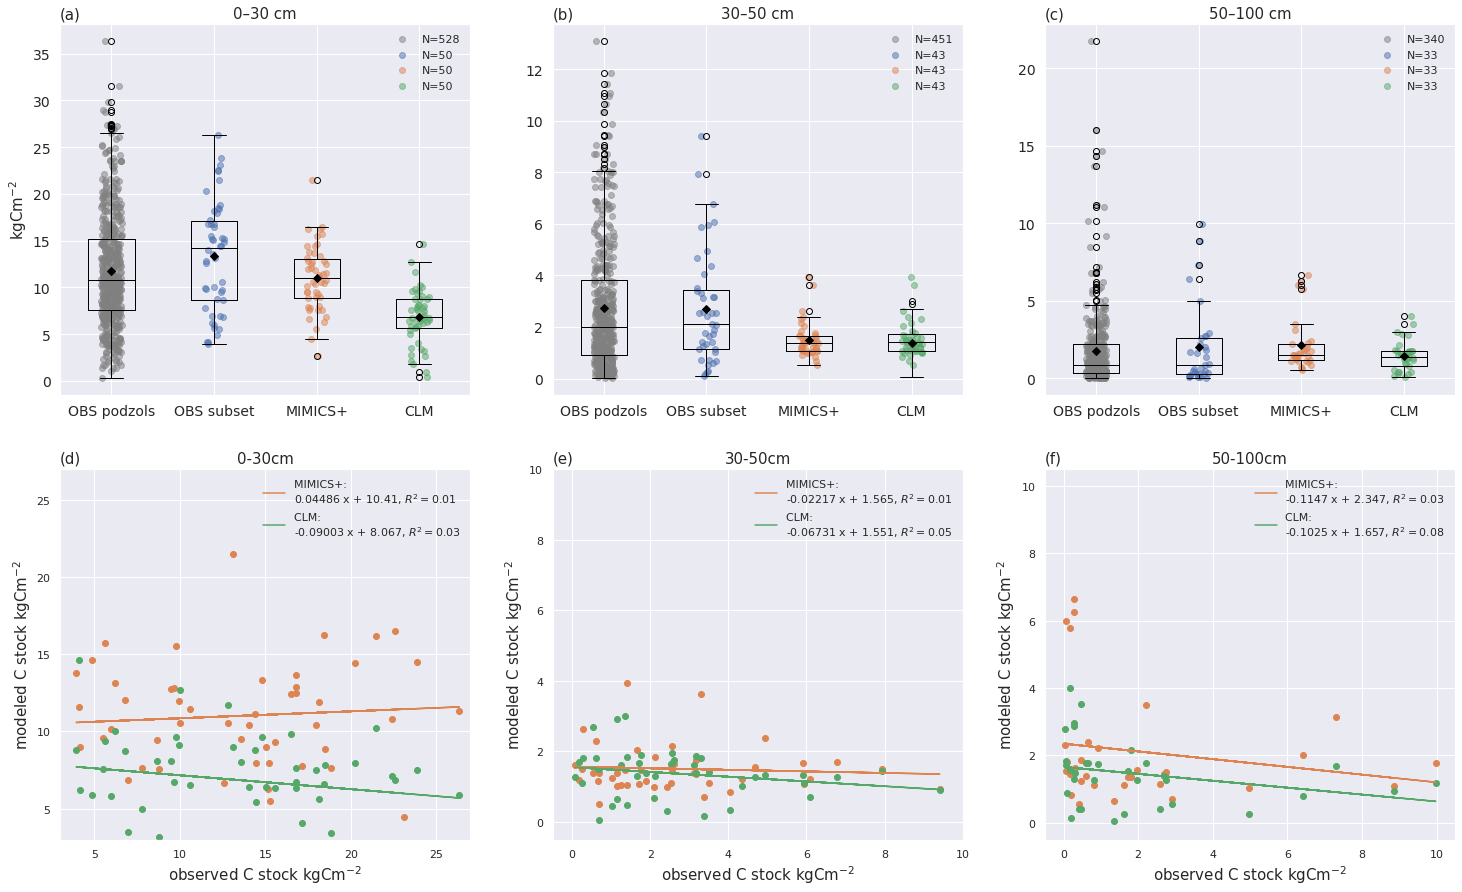

In [65]:
# Plot f02.pdf (total box plots)
sns.set_style("darkgrid")
all30     = [podz_wo_subset.stock30, obs_subset.stock30,decomp_df.stock30,CLM_df.stock30]
all30_50  = [podz_wo_subset[podz_wo_subset.stock30_50 > 0].stock30_50, obs_subset[obs_subset.stock30_50 > 0].stock30_50,decomp_df[obs_subset.stock30_50 > 0].stock30_50,CLM_df[obs_subset.stock30_50 > 0].stock30_50]
all50_100 = [podz_wo_subset[podz_wo_subset.stock50_100 > 0].stock50_100, obs_subset[obs_subset.stock50_100 > 0].stock50_100,decomp_df[obs_subset.stock50_100 > 0].stock50_100,CLM_df[obs_subset.stock50_100 > 0].stock50_100]
labels = ["OBS podzols","OBS subset","MIMICS+","CLM"]

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(25, 15))

ax1.boxplot(all30,labels = labels,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":"black","markeredgecolor":"black"});
ax1.set_title(r"(a)",fontsize = 15, loc = "left")
ax1.set_title("0–30 cm",fontsize = 15, loc = "center")
ax1.set_ylabel("$\mathrm{kgC m^{-2}}$", fontsize=15);
ax1.tick_params(axis='both', labelsize=14);ax1.grid(True)
ax1.scatter(x=[1+random.uniform(-0.1, 0.1) for i in range(len(all30[0]))],y=all30[0], label = "N=%i"%len(all30[0]),alpha=0.5,color="gray")
ax1.scatter(x=[2+random.uniform(-0.1, 0.1) for i in range(len(all30[2]))],y=all30[1], label = "N=%i"%len(all30[1]),alpha=0.5,color=colors[0])
ax1.scatter(x=[3+random.uniform(-0.1, 0.1) for i in range(len(all30[1]))],y=all30[2], label = "N=%i"%len(all30[2]),alpha=0.5,color=colors[1])
ax1.scatter(x=[4+random.uniform(-0.1, 0.1) for i in range(len(all30[3]))],y=all30[3], label = "N=%i"%len(all30[3]),alpha=0.5,color=colors[2])
ax1.legend()

ax2.boxplot(all30_50,labels = labels,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":"black","markeredgecolor":"black"});
ax2.set_title(r"(b)",fontsize = 15, loc = "left")
ax2.set_title("30–50 cm",fontsize = 15, loc = "center")
ax2.tick_params(axis='both', labelsize=14)
ax2.scatter(x=[1+random.uniform(-0.1, 0.1) for i in range(len(all30_50[0]))],y=all30_50[0], label = "N=%i"%len(all30_50[0]),alpha=0.5,color="gray")
ax2.scatter(x=[2+random.uniform(-0.1, 0.1) for i in range(len(all30_50[1]))],y=all30_50[1], label = "N=%i"%len(all30_50[1]),alpha=0.5,color=colors[0])
ax2.scatter(x=[3+random.uniform(-0.1, 0.1) for i in range(len(all30_50[2]))],y=all30_50[2], label = "N=%i"%len(all30_50[2]),alpha=0.5,color=colors[1])
ax2.scatter(x=[4+random.uniform(-0.1, 0.1) for i in range(len(all30_50[3]))],y=all30_50[2], label = "N=%i"%len(all30_50[3]),alpha=0.5,color=colors[2])
ax2.legend()


ax3.boxplot(all50_100,labels = labels,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":"black","markeredgecolor":"black"});
ax3.set_title(r"(c)",fontsize = 15, loc = "left")
ax3.set_title("50–100 cm",fontsize = 15,loc="center")
ax3.tick_params(axis='both', labelsize=14);ax3.grid(True)
ax3.scatter(x=[1+random.uniform(-0.1, 0.1) for i in range(len(all50_100[0]))],y=all50_100[0], label = "N=%i"%len(all50_100[0]),alpha=0.5,color="gray")
ax3.scatter(x=[2+random.uniform(-0.1, 0.1)for i in range(len(all50_100[1]))],y=all50_100[1], label = "N=%i"%len(all50_100[1]),alpha=0.5,color=colors[0])
ax3.scatter(x=[3+random.uniform(-0.1, 0.1)for i in range(len(all50_100[2]))],y=all50_100[2], label = "N=%i"%len(all50_100[2]),alpha=0.5,color=colors[1])
ax3.scatter(x=[4+random.uniform(-0.1, 0.1)for i in range(len(all50_100[3]))],y=all50_100[3], label = "N=%i"%len(all50_100[3]),alpha=0.5,color=colors[2])
ax3.legend()
###########################Scatterplots: #################################################
#MIMICS+
ax4.scatter(x= obs_subset.stock30,y= decomp_df.stock30,color=colors[1])
ax4.set_title(r"(d)",fontsize = 15, loc = "left")

z = np.polyfit(obs_subset.stock30, decomp_df.stock30, 1)
p = np.poly1d(z)
R2 = np.corrcoef(decomp_df.stock30,p(obs_subset.stock30))[0,1]**2
#add trendline to plot
ax4.plot(obs_subset.stock30, p(obs_subset.stock30),label="MIMICS+: "+str(p)+", $R^2=$"+str(round(R2,2)),color=colors[1])

#CLM:
ax4.scatter(x= obs_subset.stock30,y= CLM_df.stock30,color=colors[2])
z = np.polyfit(obs_subset.stock30, CLM_df.stock30, 1)
p = np.poly1d(z)
R2 = np.corrcoef(CLM_df.stock30,p(obs_subset.stock30))[0,1]**2

#add trendline to plot
ax4.plot(obs_subset.stock30, p(obs_subset.stock30),label="CLM: "+str(p)+", $R^2=$"+str(round(R2,2)),color=colors[2])

ax4.set_xlim(3,27)
ax4.set_ylim(3,27)

ax4.legend();ax4.set_xlabel("observed C stock $\mathrm{kgC m^{-2}}$",fontsize = 15);ax4.set_ylabel("modeled C stock $\mathrm{kgC m^{-2}}$",fontsize = 15);ax4.set_title("0-30cm", fontsize = 15)
#30-50cm
ax5.set_title(r"(e)",fontsize = 15, loc = "left")

ax5.scatter(x= obs_subset[obs_subset.stock30_50 > 0].stock30_50,y= decomp_df[obs_subset.stock30_50 > 0].stock30_50,color=colors[1])
z = np.polyfit(obs_subset[obs_subset.stock30_50 > 0].stock30_50, decomp_df[obs_subset.stock30_50 > 0].stock30_50, 1)
p = np.poly1d(z)
R2 = np.corrcoef(decomp_df[obs_subset.stock30_50 > 0].stock30_50,p(obs_subset[obs_subset.stock30_50 > 0].stock30_50))[0,1]**2
#add trendline to plot
ax5.plot(obs_subset[obs_subset.stock30_50 > 0].stock30_50, p(obs_subset[obs_subset.stock30_50 > 0].stock30_50),label="MIMICS+: "+str(p)+", $R^2=$"+str(round(R2,2)),color=colors[1])

ax5.scatter(x= obs_subset[obs_subset.stock30_50 > 0].stock30_50,y= CLM_df[obs_subset.stock30_50 > 0].stock30_50,color=colors[2])
z = np.polyfit(obs_subset[obs_subset.stock30_50 > 0].stock30_50, CLM_df[obs_subset.stock30_50 > 0].stock30_50, 1)
p = np.poly1d(z)
R2 = np.corrcoef(CLM_df[obs_subset.stock30_50 > 0].stock30_50,p(obs_subset[obs_subset.stock30_50 > 0].stock30_50))[0,1]**2
#add trendline to plot
ax5.plot(obs_subset[obs_subset.stock30_50 > 0].stock30_50, p(obs_subset[obs_subset.stock30_50 > 0].stock30_50),label="CLM: "+str(p)+", $R^2=$"+str(round(R2,2)),color=colors[2])

ax5.set_xlim(-0.5,10)
ax5.set_ylim(-0.5,10)
ax5.legend();ax5.set_xlabel("observed C stock $\mathrm{kgC m^{-2}}$",fontsize = 15);ax5.set_ylabel("modeled C stock $\mathrm{kgC m^{-2}}$",fontsize = 15);ax5.set_title("30-50cm", fontsize = 15)

#50-100cm
ax6.set_title(r"(f)",fontsize = 15, loc = "left")

ax6.scatter(x= obs_subset[(obs_subset.stock50_100 > 0)].stock50_100,y= decomp_df[obs_subset.stock50_100 > 0].stock50_100,color=colors[1])
z = np.polyfit(obs_subset[(obs_subset.stock50_100 > 0)].stock50_100, decomp_df[(obs_subset.stock50_100 > 0)].stock50_100, 1)
p = np.poly1d(z)
R2 = np.corrcoef(decomp_df[obs_subset.stock50_100 > 0].stock50_100,p(obs_subset[obs_subset.stock50_100 > 0].stock50_100))[0,1]**2
#add trendline to plot
ax6.plot(obs_subset[(obs_subset.stock50_100 > 0)].stock50_100, p(obs_subset[(obs_subset.stock50_100 > 0)].stock50_100),label="MIMICS+: "+str(p)+", $R^2=$"+str(round(R2,2)),color=colors[1])

ax6.scatter(x= obs_subset[(obs_subset.stock50_100 > 0)].stock50_100,y= CLM_df[(obs_subset.stock50_100 > 0)].stock50_100,color=colors[2])
z = np.polyfit(obs_subset[(obs_subset.stock50_100 > 0)].stock50_100, CLM_df[(obs_subset.stock50_100 > 0)].stock50_100, 1)
p = np.poly1d(z)
R2 = np.corrcoef(CLM_df[obs_subset.stock50_100 > 0].stock50_100,p(obs_subset[obs_subset.stock50_100 > 0].stock50_100))[0,1]**2
#add trendline to plot
ax6.plot(obs_subset[(obs_subset.stock50_100 > 0)].stock50_100, p(obs_subset[(obs_subset.stock50_100 > 0)].stock50_100),label="CLM: "+str(p)+", $R^2=$"+str(round(R2,2)),color=colors[2])
ax6.set_xlim(-0.5,10.5)
ax6.set_ylim(-0.5,10.5)

ax6.legend();ax6.set_xlabel("observed C stock $\mathrm{kgC m^{-2}}$",fontsize = 15);ax6.set_ylabel("modeled C stock $\mathrm{kgC m^{-2}}$",fontsize = 15);ax6.set_title("50-100cm",fontsize = 15)
#plt.savefig("./f02.pdf",bbox_inches="tight")

### f02 analysis 

In [66]:
def significance_ttest(data_series1,name1, data_series2,name2, alpha,equal_var):

    A = data_series1.values.tolist()
    B = data_series2.values.tolist()
    
    t_check = stats.ttest_ind(A, B,equal_var=equal_var)
    t_check
    if (t_check[1] < alpha):
        print('%s IS significantly different from %s with alpha = %1.3f' %(name1,name2,alpha))
    else:
        print('%s IS NOT significantly different from %s with alpha = %1.3f' %(name1,name2, alpha))
    print('t-statistic = %6.3f pvalue = %6.4f' % (t_check[0], t_check[1]))


print("--------------------0-30cm: -----------------------")
print("Equal variance = False --> Welch's test that does not assume equal variance: \n")
significance_ttest(obs_subset.stock30,"OBS 0-30cm",decomp_df.stock30,"MIMICS+ 0-30cm",alpha = 0.05,equal_var = False)
significance_ttest(obs_subset.stock30,"OBS 0-30cm",CLM_df.stock30,"CLM 0-30cm",alpha = 0.05,equal_var = False)
significance_ttest(decomp_df.stock30,"MIMICS+ 0-30cm",CLM_df.stock30,"CLM 0-30cm",alpha = 0.05,equal_var = False)

significance_ttest(podz_wo_subset.stock30,"podzols 0-30cm",obs_subset.stock30,"OBS 0-30cm",alpha = 0.05,equal_var = False)
significance_ttest(podz_wo_subset.stock30,"podzols 0-30cm",decomp_df.stock30,"MIMICS+ 0-30cm",alpha = 0.05,equal_var = False)
significance_ttest(podz_wo_subset.stock30,"podzols 0-30cm",CLM_df.stock30,"CLM 0-30cm",alpha = 0.05,equal_var = False)


print("\n---------------------30-50 cm: -----------------------")
print("Equal variance = False --> Welch's test that does not assume equal variance: \n")
significance_ttest(obs_subset[obs_subset.stock30_50 > 0].stock30_50,"OBS 30-50cm",decomp_df[obs_subset.stock30_50 > 0].stock30_50,"MIMICS+ 30-50cm",alpha = 0.05,equal_var = False)
significance_ttest(obs_subset[obs_subset.stock30_50 > 0].stock30_50,"OBS 30-50cm",CLM_df[obs_subset.stock30_50 > 0].stock30_50,"CLM 30-50cm",alpha = 0.05,equal_var = False)
significance_ttest(decomp_df[obs_subset.stock30_50 > 0].stock30_50,"MIMICS+ 30-50cm",CLM_df[obs_subset.stock30_50 > 0].stock30_50,"CLM 30-50cm",alpha = 0.05,equal_var = False)

significance_ttest(podz_wo_subset[podz_wo_subset.stock30_50 > 0].stock30_50,"podzols 30-50cm",obs_subset[obs_subset.stock30_50 > 0].stock30_50,"OBS 30-50cm",alpha = 0.05,equal_var = False)
significance_ttest(podz_wo_subset[podz_wo_subset.stock30_50 > 0].stock30_50,"podzols 30-50cm",decomp_df[obs_subset.stock30_50 > 0].stock30_50,"MIMICS+ 30-50cm",alpha = 0.05,equal_var = False)
significance_ttest(podz_wo_subset[podz_wo_subset.stock30_50 > 0].stock30_50,"podzols 30-50cm",CLM_df[obs_subset.stock30_50 > 0].stock30_50,"CLM 30-50cm",alpha = 0.05,equal_var = False)


print("\n---------------------50-100 cm: -----------------------")
print("Equal variance = False --> Welch's test that does not assume equal variance: \n")
significance_ttest(obs_subset[obs_subset.stock50_100 > 0].stock50_100,"OBS 50-100cm",decomp_df[obs_subset.stock50_100 > 0].stock50_100,"MIMICS+ 50-100cm",alpha = 0.05,equal_var = False)
significance_ttest(obs_subset[obs_subset.stock50_100 > 0].stock50_100,"OBS 50-100cm",CLM_df[obs_subset.stock50_100 > 0].stock50_100,"CLM 50-100cm",alpha = 0.05,equal_var = False)
significance_ttest(decomp_df[obs_subset.stock50_100 > 0].stock50_100,"MIMICS+ 50-100cm",CLM_df[obs_subset.stock50_100 > 0].stock50_100,"CLM 50-100cm",alpha = 0.05,equal_var = False)

significance_ttest(podz_wo_subset[podz_wo_subset.stock50_100 > 0].stock50_100,"podzols 50-100cm",obs_subset[obs_subset.stock50_100 > 0].stock50_100,"OBS 50-100cm",alpha = 0.05,equal_var = False)
significance_ttest(podz_wo_subset[podz_wo_subset.stock50_100 > 0].stock50_100,"podzols 50-100cm",decomp_df[obs_subset.stock50_100 > 0].stock50_100,"MIMICS+ 50-100cm",alpha = 0.05,equal_var = False)
significance_ttest(podz_wo_subset[podz_wo_subset.stock50_100 > 0].stock50_100,"podzols 50-100cm",CLM_df[obs_subset.stock50_100 > 0].stock50_100,"CLM 50-100cm",alpha = 0.05,equal_var = False)


--------------------0-30cm: -----------------------
Equal variance = False --> Welch's test that does not assume equal variance: 

OBS 0-30cm IS significantly different from MIMICS+ 0-30cm with alpha = 0.050
t-statistic =  2.427 pvalue = 0.0175
OBS 0-30cm IS significantly different from CLM 0-30cm with alpha = 0.050
t-statistic =  7.003 pvalue = 0.0000
MIMICS+ 0-30cm IS significantly different from CLM 0-30cm with alpha = 0.050
t-statistic =  6.423 pvalue = 0.0000
podzols 0-30cm IS NOT significantly different from OBS 0-30cm with alpha = 0.050
t-statistic = -1.779 pvalue = 0.0803
podzols 0-30cm IS NOT significantly different from MIMICS+ 0-30cm with alpha = 0.050
t-statistic =  1.425 pvalue = 0.1581
podzols 0-30cm IS significantly different from CLM 0-30cm with alpha = 0.050
t-statistic = 10.150 pvalue = 0.0000

---------------------30-50 cm: -----------------------
Equal variance = False --> Welch's test that does not assume equal variance: 

OBS 30-50cm IS significantly different fro

### f03 (fig:CNboxplot) plot

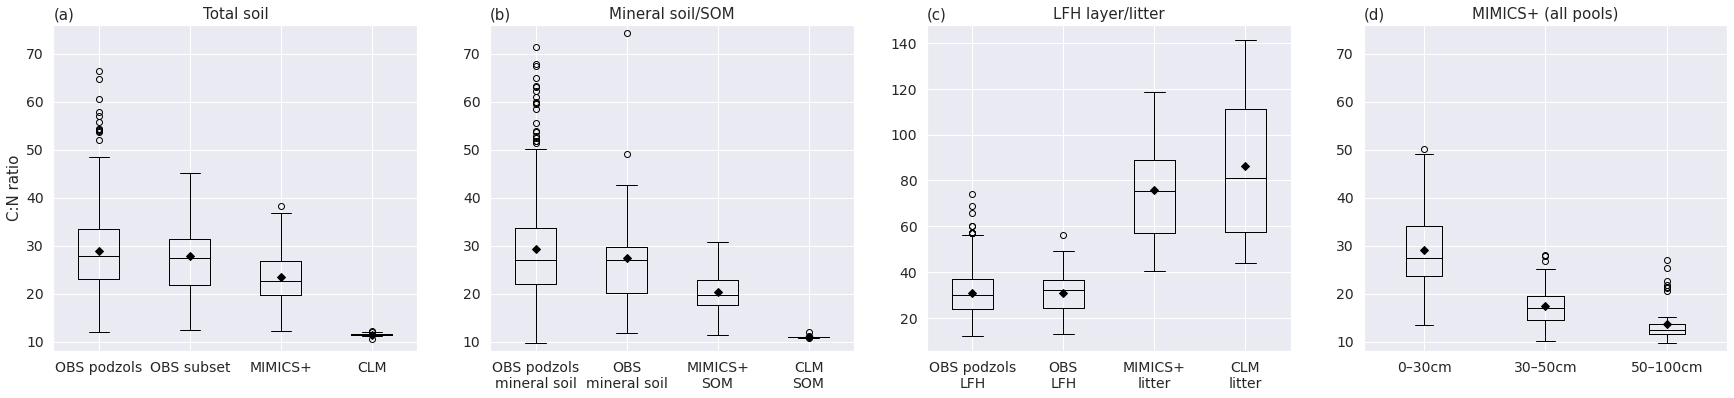

In [67]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=[30,6])

ax1.boxplot([podz_wo_subset.cstock/podz_wo_subset.nstock,obs_subset.cstock/obs_subset.nstock,decomp_df.TOTC/decomp_df.TOTN,CLM_df.TOTC/CLM_df.TOTN], labels = ["OBS podzols","OBS subset","MIMICS+","CLM"],vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":"black","markeredgecolor":"black"});
ax1.set_title("(a)",fontsize=15,loc = "left")
ax1.set_title("Total soil",fontsize=15,loc="center")
ax1.set_ylabel("C:N ratio", fontsize=15);ax1.set_ylim(8,76)
ax1.tick_params(axis='both', labelsize=14)

ax2.boxplot([(podz_wo_subset.c100min/podz_wo_subset.n100min).dropna(),obs_subset.c100min/obs_subset.n100min,decomp_df.TOTSOMC/decomp_df.TOTSOMN, CLM_df.TOTSOMC/CLM_df.TOTSOMN],labels = ["OBS podzols\nmineral soil","OBS\nmineral soil", "MIMICS+\nSOM", "CLM\nSOM"],vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":"black","markeredgecolor":"black"});
ax2.set_title("(b)",fontsize=15,loc = "left")
ax2.set_title("Mineral soil/SOM",fontsize=15,loc="center")
ax2.set_ylim(8,76)
ax2.tick_params(axis='both', labelsize=14)

ax3.boxplot([podz_wo_subset.CNFOREST.dropna(),obs_subset.CNFOREST,decomp_df.TOTLITC/decomp_df.TOTLITN,CLM_df.TOTLITC/CLM_df.TOTLITN],labels = ["OBS podzols\nLFH","OBS\nLFH","MIMICS+\nlitter","CLM\nlitter"],vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":"black","markeredgecolor":"black"});
ax3.set_title("(c)",fontsize=15,loc="left");
ax3.set_title("LFH layer/litter",fontsize=15,loc="center");
ax3.tick_params(axis='both', labelsize=14)

ax4.boxplot([decomp_df.stock30/decomp_df.Nstock30, decomp_df.stock30_50/decomp_df.Nstock30_50, decomp_df.stock50_100/decomp_df.Nstock50_100],
            labels = ["0–30cm", "30–50cm", "50–100cm"],vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":"black","markeredgecolor":"black"});
ax4.set_title("(d)",fontsize=15,loc="left");ax4.set_ylim(8,76)
ax4.set_title("MIMICS+ (all pools)",fontsize=15,loc="center");
ax4.tick_params(axis='both', labelsize=14)


#plt.savefig("./figures/f03_include_podzols.pdf",bbox_inches="tight")

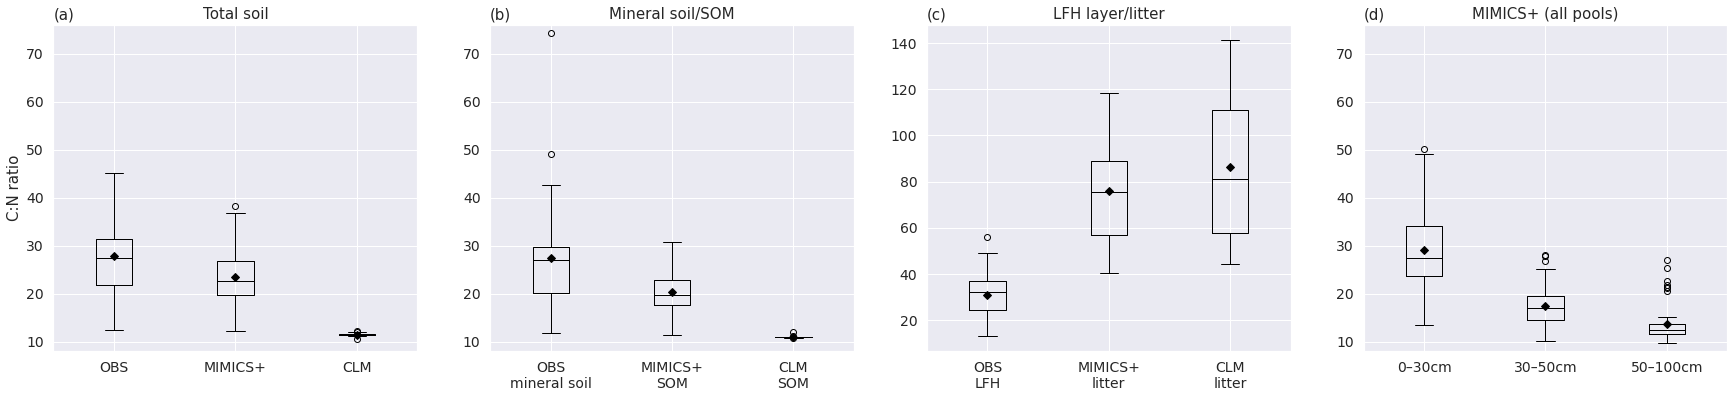

In [68]:
positions1=[.5,2.5,4.5]
positions2=[1.1,3.1,5.1]
sns.set_style("darkgrid")
fig,(ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=[30,6])

ax1.boxplot([obs_subset.cstock/obs_subset.nstock,decomp_df.TOTC/decomp_df.TOTN,CLM_df.TOTC/CLM_df.TOTN],labels = ["OBS","MIMICS+","CLM"],vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":"black","markeredgecolor":"black"});
ax1.set_title("(a)",fontsize=15,loc = "left")
ax1.set_title("Total soil",fontsize=15,loc="center")
ax1.set_ylabel("C:N ratio", fontsize=15);ax1.set_ylim(8,76)
ax1.tick_params(axis='both', labelsize=14)

ax2.boxplot([obs_subset.c100min/obs_subset.n100min,decomp_df.TOTSOMC/decomp_df.TOTSOMN, CLM_df.TOTSOMC/CLM_df.TOTSOMN],labels = ["OBS\nmineral soil", "MIMICS+\nSOM", "CLM\nSOM"],vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":"black","markeredgecolor":"black"});
ax2.set_title("(b)",fontsize=15,loc = "left")
ax2.set_title("Mineral soil/SOM",fontsize=15,loc="center")
ax2.set_ylim(8,76)
ax2.tick_params(axis='both', labelsize=14)

ax3.boxplot([obs_subset.CNFOREST,decomp_df.TOTLITC/decomp_df.TOTLITN,CLM_df.TOTLITC/CLM_df.TOTLITN],labels = ["OBS\nLFH","MIMICS+\nlitter","CLM\nlitter"],vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":"black","markeredgecolor":"black"});
ax3.set_title("(c)",fontsize=15,loc="left");
ax3.set_title("LFH layer/litter",fontsize=15,loc="center");
ax3.tick_params(axis='both', labelsize=14)

ax4.boxplot([decomp_df.stock30/decomp_df.Nstock30, decomp_df.stock30_50/decomp_df.Nstock30_50, decomp_df.stock50_100/decomp_df.Nstock50_100],
            labels = ["0–30cm", "30–50cm", "50–100cm"],vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":"black","markeredgecolor":"black"});
ax4.set_title("(d)",fontsize=15,loc="left");ax4.set_ylim(8,76)
ax4.set_title("MIMICS+ (all pools)",fontsize=15,loc="center");
ax4.tick_params(axis='both', labelsize=14)


#plt.savefig("./paper_figures/f03.pdf",bbox_inches="tight")

### f03 analysis

In [29]:
print("---SIGNIFICANCE TTESTS for CN ratios MIMICS+ vertical:  ")

significance_ttest(decomp_df.stock30/decomp_df.Nstock30,"MIMICS 0-30cm",decomp_df.stock30_50/decomp_df.Nstock30_50,"MIMICS+ 30-50cm",alpha=0.05,equal_var=False )
significance_ttest(decomp_df.stock30/decomp_df.Nstock30,"MIMICS 0-30cm",decomp_df.stock50_100/decomp_df.Nstock50_100,"MIMICS+ 50-100cm",alpha=0.05,equal_var=False )
significance_ttest(decomp_df.stock30_50/decomp_df.Nstock30_50,"MIMICS 30-50cm",decomp_df.stock50_100/decomp_df.Nstock50_100,"MIMICS+ 50-100cm",alpha=0.05,equal_var=False )

print("\n0-30cm: ")
print((decomp_df.stock30/decomp_df.Nstock30).describe())
print("30-50cm")
print((decomp_df.stock30_50/decomp_df.Nstock30_50).describe())
print("50-100cm: ")
print((decomp_df.stock50_100/decomp_df.Nstock50_100).describe())

---SIGNIFICANCE TTESTS for CN ratios MIMICS+ vertical:  
MIMICS 0-30cm IS significantly different from MIMICS+ 30-50cm with alpha = 0.050
t-statistic =  9.039 pvalue = 0.0000
MIMICS 0-30cm IS significantly different from MIMICS+ 50-100cm with alpha = 0.050
t-statistic = 12.199 pvalue = 0.0000
MIMICS 30-50cm IS significantly different from MIMICS+ 50-100cm with alpha = 0.050
t-statistic =  4.409 pvalue = 0.0000

0-30cm: 
count    50.000000
mean     29.055954
std       7.940496
min      13.350000
25%      23.749707
50%      27.353383
75%      34.011555
max      50.032258
dtype: float64
30-50cm
count    50.000000
mean     17.435791
std       4.424802
min      10.176376
25%      14.499137
50%      17.057956
75%      19.386465
max      27.949770
dtype: float64
50-100cm: 
count    50.000000
mean     13.716501
std       4.000441
min       9.758721
25%      11.541067
50%      12.484688
75%      13.655116
max      27.032875
dtype: float64


In [30]:
print("---SIGNIFICANCE TTESTS for CN ratios: ")
mf.significance_ttest(obs_subset.cstock/obs_subset.nstock,"OBS TOT CN",decomp_df.TOTC/decomp_df.TOTN,"MIMICS+ TOTCN",alpha=0.05,equal_var=False )
mf.significance_ttest(obs_subset.cstock/obs_subset.nstock,"OBS TOT CN",CLM_df.TOTC/CLM_df.TOTN,"CLM TOTCN",alpha=0.05,equal_var=False )
mf.significance_ttest(decomp_df.TOTC/decomp_df.TOTN,"MIMICS+ TOTCN",CLM_df.TOTC/CLM_df.TOTN,"CLM TOTCN",alpha=0.05,equal_var=False )
print("-----")
mf.significance_ttest(podz_wo_subset.cstock/podz_wo_subset.nstock,"OBS podzols",obs_subset.cstock/obs_subset.nstock,"OBS subset CN",alpha=0.05,equal_var=False )
mf.significance_ttest(podz_wo_subset.cstock/podz_wo_subset.nstock,"OBS podzols",decomp_df.TOTC/decomp_df.TOTN,"MIMICS+ TOTCN",alpha=0.05,equal_var=False )
mf.significance_ttest(podz_wo_subset.cstock/podz_wo_subset.nstock,"OBS podzols",CLM_df.TOTC/CLM_df.TOTN,"CLM TOTCN",alpha=0.05,equal_var=False )

print("\nOBS podzols: ")
print((podz_wo_subset.cstock/podz_wo_subset.nstock).describe())
print("\nOBS subset: ")
print((obs_subset.cstock/obs_subset.nstock).describe())
print("MIMICS+: ")
print((decomp_df.TOTC/decomp_df.TOTN).describe())
print("CLM: ")
print((CLM_df.TOTC/CLM_df.TOTN).describe())

---SIGNIFICANCE TTESTS for CN ratios: 
OBS TOT CN IS significantly different from MIMICS+ TOTCN with alpha = 0.050
t-statistic =  3.126 pvalue = 0.0024
OBS TOT CN IS significantly different from CLM TOTCN with alpha = 0.050
t-statistic = 14.566 pvalue = 0.0000
MIMICS+ TOTCN IS significantly different from CLM TOTCN with alpha = 0.050
t-statistic = 14.385 pvalue = 0.0000
-----
OBS podzols IS NOT significantly different from OBS subset CN with alpha = 0.050
t-statistic =  0.823 pvalue = 0.4135
OBS podzols IS significantly different from MIMICS+ TOTCN with alpha = 0.050
t-statistic =  5.863 pvalue = 0.0000
OBS podzols IS significantly different from CLM TOTCN with alpha = 0.050
t-statistic = 46.619 pvalue = 0.0000

OBS podzols: 
count    528.000000
mean      28.849415
std        8.540941
min       12.036649
25%       23.124722
50%       27.800609
75%       33.405464
max       66.500000
dtype: float64

OBS subset: 
count    50.000000
mean     27.872200
std       7.968959
min      12.392157

In [31]:
print("---SIGNIFICANCE TTESTS for CN ratios in mineral soil: ")
mf.significance_ttest(obs_subset.c100min/obs_subset.n100min,"OBS mineral CN",decomp_df.TOTSOMC/decomp_df.TOTSOMN,"MIMICS+ SOM CN",alpha=0.05,equal_var=False )
mf.significance_ttest(obs_subset.c100min/obs_subset.c100min,"OBS mineral soil CN",CLM_df.TOTSOMC/CLM_df.TOTSOMN,"CLM TOTSOMCN",alpha=0.05,equal_var=False )
mf.significance_ttest(decomp_df.TOTSOMC/decomp_df.TOTSOMN,"MIMICS+ TOTSOMCN",CLM_df.TOTSOMC/CLM_df.TOTSOMN,"CLM TOTSOMCN",alpha=0.05,equal_var=False )
print("-----")
mf.significance_ttest((podz_wo_subset.c100min/podz_wo_subset.n100min).notna(),"OBS podzols",obs_subset.c100min/obs_subset.n100min,"OBS mineral soil CN",alpha=0.05,equal_var=False )
mf.significance_ttest((podz_wo_subset.c100min/podz_wo_subset.n100min).notna(),"OBS podzols",decomp_df.TOTSOMC/decomp_df.TOTSOMN,"MIMICS+ TOTSOMCN",alpha=0.05,equal_var=False )
mf.significance_ttest((podz_wo_subset.c100min/podz_wo_subset.n100min).notna(),"OBS podzols",CLM_df.TOTSOMC/CLM_df.TOTSOMN,"CLM TOTSOMCN",alpha=0.05,equal_var=False )

print("\nOBS podzols: ")
print((podz_wo_subset.c100min/podz_wo_subset.n100min).describe())
print("\nOBS: ")
print((obs_subset.c100min/obs_subset.n100min).describe())
print("MIMICS+: ")
print((decomp_df.TOTSOMC/decomp_df.TOTSOMN).describe())
print("CLM: ")
print((CLM_df.TOTSOMC/CLM_df.TOTSOMN).describe())

---SIGNIFICANCE TTESTS for CN ratios in mineral soil: 
OBS mineral CN IS significantly different from MIMICS+ SOM CN with alpha = 0.050
t-statistic =  4.424 pvalue = 0.0000
OBS mineral soil CN IS significantly different from CLM TOTSOMCN with alpha = 0.050
t-statistic = -436.874 pvalue = 0.0000
MIMICS+ TOTSOMCN IS significantly different from CLM TOTSOMCN with alpha = 0.050
t-statistic = 14.770 pvalue = 0.0000
-----
OBS podzols IS significantly different from OBS mineral soil CN with alpha = 0.050
t-statistic = -17.921 pvalue = 0.0000
OBS podzols IS significantly different from MIMICS+ TOTSOMCN with alpha = 0.050
t-statistic = -30.714 pvalue = 0.0000
OBS podzols IS significantly different from CLM TOTSOMCN with alpha = 0.050
t-statistic = -391.210 pvalue = 0.0000

OBS podzols: 
count    486.000000
mean      29.295817
std       12.331745
min        9.769231
25%       21.913281
50%       26.975000
75%       33.594737
max      143.000000
dtype: float64

OBS: 
count    50.000000
mean     2

In [32]:
print("---SIGNIFICANCE TTESTS for LFH/litter  ratios: ")
mf.significance_ttest(obs_subset.CNFOREST,"OBS LFH CN",decomp_df.TOTLITC/decomp_df.TOTLITN,"MIMICS+ LITCN",alpha=0.05,equal_var=False )
mf.significance_ttest(obs_subset.CNFOREST,"OBS LFH CN",CLM_df.TOTLITC/CLM_df.TOTLITN,"CLM LITCN",alpha=0.05,equal_var=False )
mf.significance_ttest(decomp_df.TOTLITC/decomp_df.TOTLITN,"MIMICS+ LITCN",CLM_df.TOTLITC/CLM_df.TOTLITN,"CLM LITCN",alpha=0.05,equal_var=False )
print("-----")
mf.significance_ttest(podz_wo_subset.CNFOREST.notna(),"OBS podzols",obs_subset.CNFOREST,"OBS subset CNFOREST",alpha=0.05,equal_var=False )
mf.significance_ttest(podz_wo_subset.CNFOREST.notna(),"OBS podzols",decomp_df.TOTLITC/decomp_df.TOTLITN,"MIMICS+ LITCN",alpha=0.05,equal_var=False )
mf.significance_ttest(podz_wo_subset.CNFOREST.notna(),"OBS podzols",CLM_df.TOTC/CLM_df.TOTN,"CLM TOTCN",alpha=0.05,equal_var=False )

print("\nOBS podzols: ")
print((podz_wo_subset.CNFOREST).describe())
print("\nOBS: ")
print((obs_subset.CNFOREST).describe())
print("MIMICS+: ")
print((decomp_df.TOTLITC/decomp_df.TOTLITN).describe())
print("CLM: ")
print((CLM_df.TOTLITC/CLM_df.TOTLITN).describe())

---SIGNIFICANCE TTESTS for LFH/litter  ratios: 
OBS LFH CN IS significantly different from MIMICS+ LITCN with alpha = 0.050
t-statistic = -14.132 pvalue = 0.0000
OBS LFH CN IS significantly different from CLM LITCN with alpha = 0.050
t-statistic = -12.732 pvalue = 0.0000
MIMICS+ LITCN IS significantly different from CLM LITCN with alpha = 0.050
t-statistic = -2.093 pvalue = 0.0393
-----
OBS podzols IS significantly different from OBS subset CNFOREST with alpha = 0.050
t-statistic = -21.768 pvalue = 0.0000
OBS podzols IS significantly different from MIMICS+ LITCN with alpha = 0.050
t-statistic = -26.236 pvalue = 0.0000
OBS podzols IS significantly different from CLM TOTCN with alpha = 0.050
t-statistic = -306.076 pvalue = 0.0000

OBS podzols: 
count    522.000000
mean      30.934866
std        9.098078
min       12.000000
25%       24.000000
50%       30.000000
75%       37.000000
max       74.000000
Name: CNFOREST, dtype: float64

OBS: 
count    50.000000
mean     31.080000
std       9

### f04 (fig:boxplot_fraction) plot

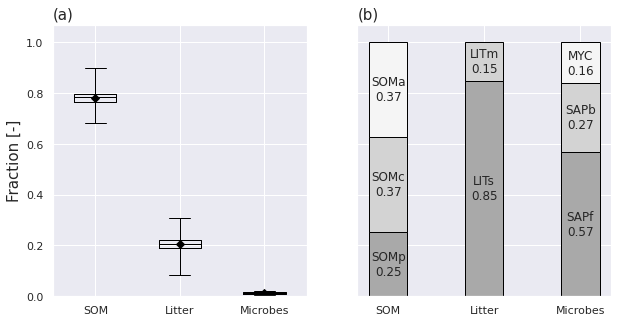

In [33]:
sns.set_style("darkgrid")
# Boxplots of fraction of SOC pools:
label = ["SOM","Litter","Microbes"]
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=[10,5],sharey=True)
ax1.boxplot(x = [((decomp_df.SOMp + decomp_df.SOMc+decomp_df.SOMa)/1000)/decomp_df.TOTC,
                  ((decomp_df.LITm+decomp_df.LITs)/1000)/decomp_df.TOTC,            
                (decomp_df.MYC+decomp_df.SAP)/decomp_df.TOTC],
                labels = label,showmeans=True,medianprops={"color":"black"},
                meanprops={"marker":"D","markerfacecolor":"black","markeredgecolor":"black"}, whis=[0,100],
                widths=0.5);
ax1.set_ylabel("Fraction [-]",fontsize=15);
ax1.set_title("(a)",loc="left",fontsize=15);


tot_mic = decomp_df.SAPb+decomp_df.SAPf+decomp_df.EcM+decomp_df.AM
tot_LIT = decomp_df.LITm + decomp_df.LITs
tot_som = decomp_df.SOMp+decomp_df.SOMa+decomp_df.SOMc

a_frac = decomp_df.SOMa/tot_som
c_frac = decomp_df.SOMc/tot_som
p_frac = decomp_df.SOMp/tot_som

am_frac = decomp_df.AM/tot_mic
ecm_frac = decomp_df.EcM/tot_mic
f_frac = decomp_df.SAPf/tot_mic
b_frac = decomp_df.SAPb/tot_mic

m_frac = decomp_df.LITm/tot_LIT
s_frac = decomp_df.LITs/tot_LIT

width=0.4
ecolor="black"
p=ax2.bar(label[0],p_frac.mean(),width=width,color="darkgray", edgecolor=ecolor)
c=ax2.bar(label[0],c_frac.mean(),bottom=p_frac.mean(),width=width,color="lightgray", edgecolor=ecolor)
a=ax2.bar(label[0],a_frac.mean(),bottom=p_frac.mean()+c_frac.mean(),width=width,color="whitesmoke", edgecolor=ecolor)

s=ax2.bar(label[1],s_frac.mean(),width=width,color="darkgray", edgecolor=ecolor)
m=ax2.bar(label[1],m_frac.mean(),bottom=s_frac.mean(),width=width,color="lightgray", edgecolor=ecolor)

f=ax2.bar(label[2],f_frac.mean(),width=width,color="darkgray", edgecolor=ecolor)
b=ax2.bar(label[2],b_frac.mean(),bottom=f_frac.mean(),width=width,color="lightgray", edgecolor=ecolor)
my=ax2.bar(label[2],ecm_frac.mean()+am_frac.mean(),bottom=f_frac.mean()+b_frac.mean(),width=width,color="whitesmoke", edgecolor=ecolor)

ax2.bar_label(p, fmt='SOMp\n%1.2f'%p_frac.mean(),label_type="center")
ax2.bar_label(c, fmt='SOMc\n%1.2f'%c_frac.mean(),label_type="center")
ax2.bar_label(a, fmt='SOMa\n%1.2f'%a_frac.mean(),label_type="center")
ax2.bar_label(s, fmt='LITs\n%1.2f'%s_frac.mean(),label_type="center")
ax2.bar_label(m, fmt='LITm\n%1.2f'%m_frac.mean(),label_type="center")
ax2.bar_label(f, fmt='SAPf\n%1.2f'%f_frac.mean(),label_type="center")
ax2.bar_label(b, fmt='SAPb\n%1.2f'%b_frac.mean(),label_type="center")
ax2.bar_label(my, fmt='MYC\n%1.2f'%(ecm_frac.mean()+am_frac.mean()),label_type="center")
ax2.set_title("(b)",loc="left",fontsize=15);
ax2.set_ylim(0,1.07);

#plt.savefig("./f04.pdf",bbox_inches="tight")


In [34]:
#SOM fraction:
print((((decomp_df.SOMp + decomp_df.SOMc+decomp_df.SOMa)/1000)/decomp_df.TOTC).describe())
#Microbial fraction:
print(((decomp_df.MYC+decomp_df.SAP)/decomp_df.TOTC).describe())
#Amount in protected pools:
print(0.37+0.25)
#Litter pools:
print((((decomp_df.LITs)/1000)/decomp_df.TOTC).mean())
print((((decomp_df.LITm)/1000)/decomp_df.TOTC).mean())
#F:B ratio
((decomp_df.SAPf/decomp_df.SAPb).describe())

count    50.000000
mean      0.780078
std       0.042857
min       0.681868
25%       0.764389
50%       0.782935
75%       0.798131
max       0.898103
dtype: float64
count    50.000000
mean      0.012204
std       0.003858
min       0.003773
25%       0.009388
50%       0.011700
75%       0.015913
max       0.019694
dtype: float64
0.62
0.17733531570426928
0.03038269157683116


count    50.000000
mean      2.191552
std       0.564592
min       1.481084
25%       1.798293
50%       2.070283
75%       2.340138
max       4.374587
dtype: float64

### f05 (fig:heatmap) plot

In [35]:
def plot_correlation_matrix(dataframe, cut_off, method,save_bol=False,save_name=None):
    #https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
    df = dataframe.corr(method=method)
    mask = np.triu(np.ones_like(df, dtype=bool))
    mask |= np.abs(df) < cut_off
    dataframe_copy = df[~mask]  # fill in NaN in the non-desired cells
    nr_of_vars = len(dataframe_copy)
  
    if method == "spearman":
        pval = dataframe.corr(method=lambda x, y: spearmanr(x, y)[
                              1]) - np.eye(*dataframe_copy.shape)
        title = "Spearman correlation heatmap"
  
    elif method == "pearson":
        pval = dataframe.corr(method=lambda x, y: pearsonr(x, y)[
                              1]) - np.eye(*dataframe_copy.shape)

    else:
        print("Invalid method")

    p = pval.applymap(lambda x: ''.join(
        ['*' for t in [.05, .01, .001] if x <= t]))

    with sns.axes_style("dark"):
        f, ax = plt.subplots(figsize=(0.9*nr_of_vars, 0.7*nr_of_vars))
        ax = sns.heatmap(dataframe_copy, vmin=-1, vmax=1, annot=dataframe_copy.round(2).astype(
            str) + p, fmt='', annot_kws={"size": 10}, mask=mask, linewidth=.3, cmap="coolwarm")
        plt.yticks(rotation=0)
    ax.set_title(title, fontsize = 15)
    textstr = '\n '.join((
            r'Significance level:',
            r'***   : $\alpha   =   0.001$ ',
            r'**    : $\alpha   =   0.01$ ',
            r'*      : $\alpha   =   0.05$ '))

    # these are matplotlib.patch.Patch properties
    props = dict( facecolor='white', alpha=0.9)

    # place a text box in upper left in axes coords
    ax.text(0.76, 0.99, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props,multialignment="left")
    if save_bol:
        f.savefig("./paper_figures/%s.pdf"%save_name,bbox_inches="tight")

    

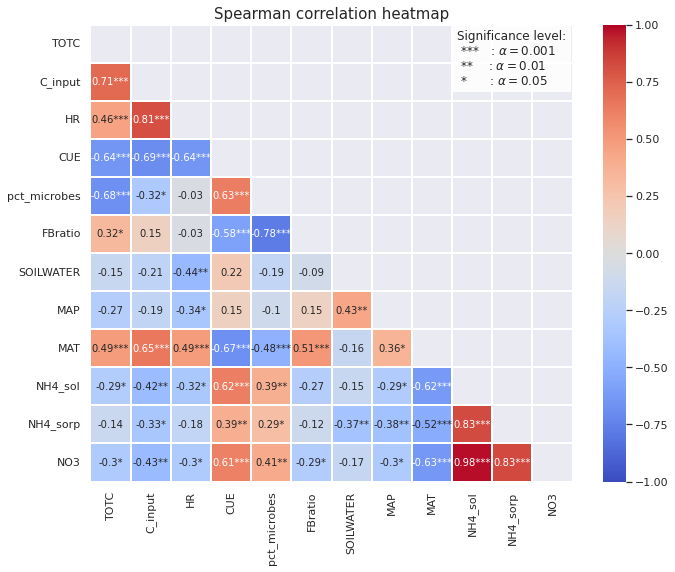

In [36]:
plot_correlation_matrix(decomp_df.rename(columns={"TOTC_input":"C_input","HR_flux":"HR"})[["TOTC","C_input","HR","CUE","pct_microbes","FBratio","SOILWATER","MAP","MAT","NH4_sol","NH4_sorp","NO3"]],cut_off = 0.0,method="spearman",save_bol=False,save_name="f05")

#### fig:obs_heatmap

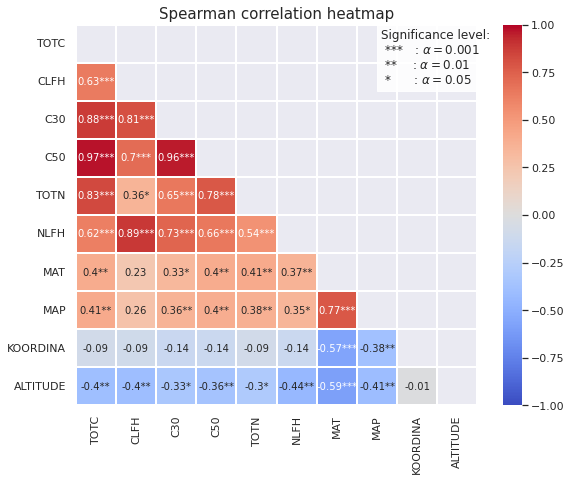

In [37]:
plot_correlation_matrix(obs_subset.rename(columns={"cstock":"TOTC","nstock":"TOTN"})[["TOTC","CLFH","C30","C50","TOTN","NLFH","MAT","MAP","KOORDINA","ALTITUDE"]],cut_off = 0.0,method="spearman",save_bol=False,save_name="obs_heatmap")

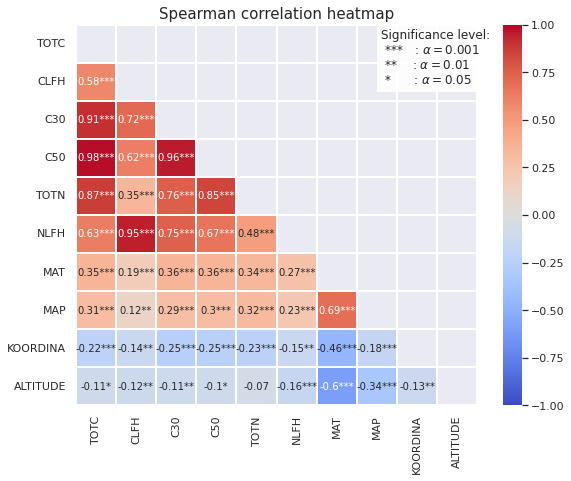

In [38]:
plot_correlation_matrix(podz_wo_subset.rename(columns={"cstock":"TOTC","nstock":"TOTN"})[["TOTC","CLFH","C30","C50","TOTN","NLFH","MAT","MAP","KOORDINA","ALTITUDE"]],cut_off = 0.0,method="spearman",save_bol=False,save_name="podzol_heatmap")

#### fig:CLM_heatmap

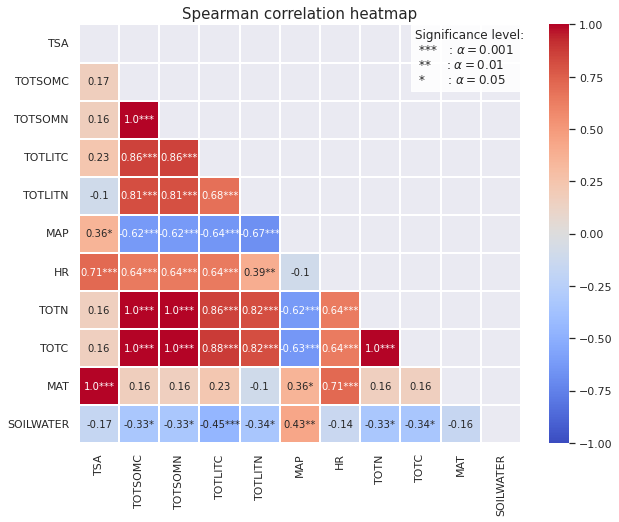

In [39]:
plot_correlation_matrix(CLM_df[['TSA', 'TOTSOMC', 'TOTSOMN', 'TOTLITC','TOTLITN', 'MAP', 'HR', 'TOTN', 'TOTC', 'MAT', 'SOILWATER']],cut_off = 0.0,method="spearman",save_bol=False,save_name="CLM_heatmap")

### f06 (fig:clim_profile) plot

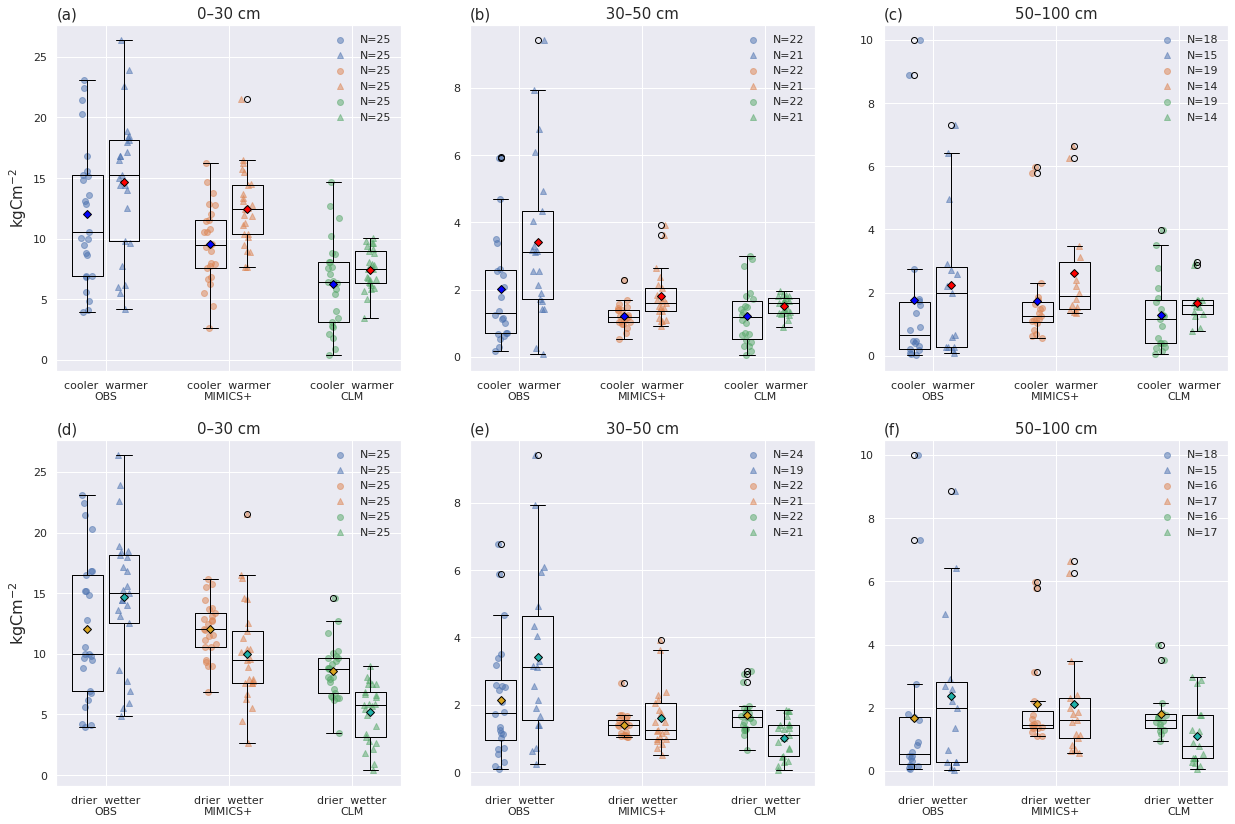

In [40]:
#Distributions where sites are removed from OBS distributions AND modeled distributions if stock is zero for OBS

#Wetter and drier: 
w30 = [obs_subset.query("MAP_cat=='wetter'").stock30,decomp_df.query("MAP_cat=='wetter'").stock30,CLM_df.query("MAP_cat=='wetter'").stock30]
d30 = [obs_subset.query("MAP_cat=='drier'").stock30,decomp_df.query("MAP_cat=='drier'").stock30,CLM_df.query("MAP_cat=='drier'").stock30]

w30_50 = [obs_subset.query("MAP_cat=='wetter'")[obs_subset.stock30_50 > 0].stock30_50,decomp_df.query("MAP_cat=='wetter'")[obs_subset.stock30_50 > 0].stock30_50,CLM_df.query("MAP_cat=='wetter'")[obs_subset.stock30_50 > 0].stock30_50]

d30_50 = [ obs_subset.query("MAP_cat=='drier'")[obs_subset.stock30_50 > 0].stock30_50,decomp_df.query("MAP_cat=='drier'")[obs_subset.stock30_50 > 0].stock30_50,CLM_df.query("MAP_cat=='drier'")[obs_subset.stock30_50 > 0].stock30_50]

w50_100 = [ obs_subset.query("MAP_cat=='wetter'")[obs_subset.stock50_100 > 0].stock50_100, decomp_df.query("MAP_cat=='wetter'")[obs_subset.stock50_100 > 0].stock50_100,CLM_df.query("MAP_cat=='wetter'")[obs_subset.stock50_100 > 0].stock50_100]
d50_100 = [ obs_subset.query("MAP_cat=='drier'")[obs_subset.stock50_100 > 0].stock50_100, decomp_df.query("MAP_cat=='drier'")[obs_subset.stock50_100 > 0].stock50_100, CLM_df.query("MAP_cat=='drier'")[obs_subset.stock50_100 > 0].stock50_100]

#warmer and cooler
c30 = [ obs_subset.query("MAT_cat=='cooler'").stock30,decomp_df.query("MAT_cat=='cooler'").stock30,CLM_df.query("MAT_cat=='cooler'").stock30]
wa30 = [ obs_subset.query("MAT_cat=='warmer'").stock30,decomp_df.query("MAT_cat=='warmer'").stock30,CLM_df.query("MAT_cat=='warmer'").stock30]
        
c30_50 = [obs_subset.query("MAT_cat=='cooler'")[obs_subset.stock30_50 > 0].stock30_50,decomp_df.query("MAT_cat=='cooler'")[obs_subset.stock30_50 > 0].stock30_50,CLM_df.query("MAT_cat=='cooler'")[obs_subset.stock30_50 > 0].stock30_50]
wa30_50 = [ obs_subset.query("MAT_cat=='warmer'")[obs_subset.stock30_50 > 0].stock30_50, decomp_df.query("MAT_cat=='warmer'")[obs_subset.stock30_50 > 0].stock30_50, CLM_df.query("MAT_cat=='warmer'")[obs_subset.stock30_50 > 0].stock30_50]

c50_100 = [ obs_subset.query("MAT_cat=='cooler'")[obs_subset.stock50_100 > 0].stock50_100, decomp_df.query("MAT_cat=='cooler'")[obs_subset.stock50_100 > 0].stock50_100, CLM_df.query("MAT_cat=='cooler'")[obs_subset.stock50_100 > 0].stock50_100]
wa50_100 = [  obs_subset.query("MAT_cat=='warmer'")[obs_subset.stock50_100 > 0].stock50_100,  decomp_df.query("MAT_cat=='warmer'")[obs_subset.stock50_100 > 0].stock50_100,  CLM_df.query("MAT_cat=='warmer'")[obs_subset.stock50_100 > 0].stock50_100]

font_dict={"fontsize":"x-large","fontweight":"bold"}
labels_1stline_MAP=["drier  wetter","drier  wetter","drier  wetter"]
labels_1stline_MAT=["cooler  warmer","cooler  warmer","cooler  warmer"]
labels_2ndline=["\nOBS","\nMIMICS+","\nCLM"]
positions1=[.5,2.5,4.5]
positions2=[1.1,3.1,5.1]
ticks_pos=[0.8,2.8,4.8,0.8,2.8,4.8]

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(21, 14))

ax1.boxplot(c30,positions=positions1,labels = labels_1stline_MAT,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":temp_colors[0],"markeredgecolor":"black"});
ax1.boxplot(wa30,positions=positions2,labels = labels_2ndline,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":temp_colors[1],"markeredgecolor":"black"});
ax1.set_title("(a)",fontsize = 15, loc = "left");
ax1.set_title("0–30 cm",fontsize = 15, loc = "center");
ax1.set_ylabel("$\mathrm{kgC m^{-2}}$",fontsize=15);
ax1.set_xticks(ticks_pos);
ax1.scatter(x=[positions1[0]+random.uniform(-0.1, 0.1) for i in range(len(c30[0]))],y=c30[0], label = "N=%i"%len(c30[0]),color=colors[0],alpha=0.5)
ax1.scatter(x=[positions2[0]+random.uniform(-0.1, 0.1) for i in range(len(wa30[0]))],y=wa30[0], label = "N=%i"%len(wa30[0]),color=colors[0],alpha=0.5,marker='^')

ax1.scatter(x=[positions1[1]+random.uniform(-0.1, 0.1) for i in range(len(c30[1]))],y=c30[1], label = "N=%i"%len(c30[1]),color=colors[1],alpha=0.5)
ax1.scatter(x=[positions2[1]+random.uniform(-0.1, 0.1) for i in range(len(wa30[1]))],y=wa30[1], label = "N=%i"%len(wa30[1]),color=colors[1],alpha=0.5,marker='^')

ax1.scatter(x=[positions1[2]+random.uniform(-0.1, 0.1) for i in range(len(c30[2]))],y=c30[2], label = "N=%i"%len(c30[2]),color=colors[2],alpha=0.5)
ax1.scatter(x=[positions2[2]+random.uniform(-0.1, 0.1) for i in range(len(wa30[2]))],y=wa30[2], label = "N=%i"%len(wa30[2]),color=colors[2],alpha=0.5,marker='^')
ax1.legend()

ax2.boxplot(c30_50,positions=positions1,labels = labels_1stline_MAT,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":temp_colors[0],"markeredgecolor":"black"});
ax2.boxplot(wa30_50,positions=positions2,labels = labels_2ndline,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":temp_colors[1],"markeredgecolor":"black"});
ax2.set_title("(b)", fontsize = 15, loc = "left")
ax2.set_title(" 30–50 cm ", fontsize = 15, loc = "center")
ax2.set_xticks(ticks_pos);
ax2.scatter(x=[positions1[0]+random.uniform(-0.1, 0.1) for i in range(len(c30_50[0]))],y=c30_50[0], label = "N=%i"%len(c30_50[0]),color=colors[0],alpha=0.5)
ax2.scatter(x=[positions2[0]+random.uniform(-0.1, 0.1) for i in range(len(wa30_50[0]))],y=wa30_50[0], label = "N=%i"%len(wa30_50[0]),color=colors[0],alpha=0.5,marker='^')
ax2.scatter(x=[positions1[1]+random.uniform(-0.1, 0.1) for i in range(len(c30_50[1]))],y=c30_50[1], label = "N=%i"%len(c30_50[1]),color=colors[1],alpha=0.5)
ax2.scatter(x=[positions2[1]+random.uniform(-0.1, 0.1) for i in range(len(wa30_50[1]))],y=wa30_50[1], label = "N=%i"%len(wa30_50[1]),color=colors[1],alpha=0.5,marker='^')
ax2.scatter(x=[positions1[2]+random.uniform(-0.1, 0.1) for i in range(len(c30_50[2]))],y=c30_50[2], label = "N=%i"%len(c30_50[2]),color=colors[2],alpha=0.5)
ax2.scatter(x=[positions2[2]+random.uniform(-0.1, 0.1) for i in range(len(wa30_50[2]))],y=wa30_50[2], label = "N=%i"%len(wa30_50[2]),color=colors[2],alpha=0.5,marker='^')
ax2.legend()

ax3.boxplot(c50_100,positions=positions1,vert=True,showmeans=True,labels = labels_1stline_MAT,medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":temp_colors[0],"markeredgecolor":"black"});
ax3.boxplot(wa50_100,positions=positions2,vert=True,showmeans=True,labels = labels_2ndline,medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":temp_colors[1],"markeredgecolor":"black"});
ax3.set_title("(c)",fontsize = 15, loc = "left");
ax3.set_title("50–100 cm",fontsize = 15, loc = "center");
ax3.set_xticks(ticks_pos);
ax3.scatter(x=[positions1[0]+random.uniform(-0.1, 0.1) for i in range(len(c50_100[0]))],y=c50_100[0], label = "N=%i"%len(c50_100[0]),color=colors[0],alpha=0.5)
ax3.scatter(x=[positions2[0]+random.uniform(-0.1, 0.1) for i in range(len(wa50_100[0]))],y=wa50_100[0], label = "N=%i"%len(wa50_100[0]),color=colors[0],alpha=0.5,marker='^')
ax3.scatter(x=[positions1[1]+random.uniform(-0.1, 0.1) for i in range(len(c50_100[1]))],y=c50_100[1], label = "N=%i"%len(c50_100[1]),color=colors[1],alpha=0.5)
ax3.scatter(x=[positions2[1]+random.uniform(-0.1, 0.1) for i in range(len(wa50_100[1]))],y=wa50_100[1], label = "N=%i"%len(wa50_100[1]),color=colors[1],alpha=0.5,marker='^')
ax3.scatter(x=[positions1[2]+random.uniform(-0.1, 0.1) for i in range(len(c50_100[2]))],y=c50_100[2], label = "N=%i"%len(c50_100[2]),color=colors[2],alpha=0.5)
ax3.scatter(x=[positions2[2]+random.uniform(-0.1, 0.1) for i in range(len(wa50_100[2]))],y=wa50_100[2], label = "N=%i"%len(wa50_100[2]),color=colors[2],alpha=0.5,marker='^')
ax3.legend()

ax4.boxplot(d30,positions=positions1,labels = labels_1stline_MAP,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":prec_colors[0],"markeredgecolor":"black"});
ax4.boxplot(w30,positions=positions2,labels = labels_2ndline,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":prec_colors[1],"markeredgecolor":"black"});
ax4.set_title("(d)",fontsize = 15, loc = "left");
ax4.set_title("0–30 cm",fontsize = 15, loc = "center");
ax4.set_ylabel("$\mathrm{kgC m^{-2}}$",fontsize=16);
ax4.set_xticks(ticks_pos);
ax4.scatter(x=[positions1[0]+random.uniform(-0.1, 0.1) for i in range(len(d30[0]))],y=d30[0], label = "N=%i"%len(d30[0]),color=colors[0],alpha=0.5)
ax4.scatter(x=[positions2[0]+random.uniform(-0.1, 0.1) for i in range(len(w30[0]))],y=w30[0], label = "N=%i"%len(w30[0]),color=colors[0],alpha=0.5,marker='^')
ax4.scatter(x=[positions1[1]+random.uniform(-0.1, 0.1) for i in range(len(d30[1]))],y=d30[1], label = "N=%i"%len(d30[1]),color=colors[1],alpha=0.5)
ax4.scatter(x=[positions2[1]+random.uniform(-0.1, 0.1) for i in range(len(w30[1]))],y=w30[1], label = "N=%i"%len(w30[1]),color=colors[1],alpha=0.5,marker='^')
ax4.scatter(x=[positions1[2]+random.uniform(-0.1, 0.1) for i in range(len(d30[2]))],y=d30[2], label = "N=%i"%len(d30[2]),color=colors[2],alpha=0.5)
ax4.scatter(x=[positions2[2]+random.uniform(-0.1, 0.1) for i in range(len(w30[2]))],y=w30[2], label = "N=%i"%len(w30[2]),color=colors[2],alpha=0.5,marker='^')
ax4.legend()

ax5.boxplot(d30_50,positions=positions1,labels = labels_1stline_MAP,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":prec_colors[0],"markeredgecolor":"black"});
ax5.boxplot(w30_50,positions=positions2,labels =labels_2ndline,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":prec_colors[1],"markeredgecolor":"black"});
ax5.set_title("(e)",fontsize = 15, loc = "left");
ax5.set_title("30–50 cm",fontsize = 15, loc = "center");
ax5.set_xticks(ticks_pos);
ax5.scatter(x=[positions1[0]+random.uniform(-0.1, 0.1) for i in range(len(d30_50[0]))],y=d30_50[0], label = "N=%i"%len(d30_50[0]),color=colors[0],alpha=0.5)
ax5.scatter(x=[positions2[0]+random.uniform(-0.1, 0.1) for i in range(len(w30_50[0]))],y=w30_50[0], label = "N=%i"%len(w30_50[0]),color=colors[0],alpha=0.5,marker='^')
ax5.scatter(x=[positions1[1]+random.uniform(-0.1, 0.1) for i in range(len(d30_50[1]))],y=d30_50[1], label = "N=%i"%len(d30_50[1]),color=colors[1],alpha=0.5)
ax5.scatter(x=[positions2[1]+random.uniform(-0.1, 0.1) for i in range(len(w30_50[1]))],y=w30_50[1], label = "N=%i"%len(w30_50[1]),color=colors[1],alpha=0.5,marker='^')
ax5.scatter(x=[positions1[2]+random.uniform(-0.1, 0.1) for i in range(len(d30_50[2]))],y=d30_50[2], label = "N=%i"%len(d30_50[2]),color=colors[2],alpha=0.5)
ax5.scatter(x=[positions2[2]+random.uniform(-0.1, 0.1) for i in range(len(w30_50[2]))],y=w30_50[2], label = "N=%i"%len(w30_50[2]),color=colors[2],alpha=0.5,marker='^')
ax5.legend()

ax6.boxplot(d50_100,positions=positions1,labels = labels_1stline_MAP,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":prec_colors[0],"markeredgecolor":"black"});
ax6.boxplot(w50_100,positions=positions2,labels =labels_2ndline,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":prec_colors[1],"markeredgecolor":"black"});
ax6.set_title(r"$c)$"+"\t\t\t50-100 cm",fontsize = 15, loc = "left");
ax6.set_title(r"(f)",fontsize = 15, loc = "left");
ax6.set_title("50–100 cm",fontsize = 15, loc = "center");
ax6.set_xticks(ticks_pos);
ax6.scatter(x=[positions1[0]+random.uniform(-0.1, 0.1) for i in range(len(d50_100[0]))],y=d50_100[0], label = "N=%i"%len(d50_100[0]),color=colors[0],alpha=0.5)
ax6.scatter(x=[positions2[0]+random.uniform(-0.1, 0.1) for i in range(len(w50_100[0]))],y=w50_100[0], label = "N=%i"%len(w50_100[0]),color=colors[0],alpha=0.5,marker='^')
ax6.scatter(x=[positions1[1]+random.uniform(-0.1, 0.1) for i in range(len(d50_100[1]))],y=d50_100[1], label = "N=%i"%len(d50_100[1]),color=colors[1],alpha=0.5)
ax6.scatter(x=[positions2[1]+random.uniform(-0.1, 0.1) for i in range(len(w50_100[1]))],y=w50_100[1], label = "N=%i"%len(w50_100[1]),color=colors[1],alpha=0.5,marker='^')
ax6.scatter(x=[positions1[2]+random.uniform(-0.1, 0.1) for i in range(len(d50_100[2]))],y=d50_100[2], label = "N=%i"%len(d50_100[2]),color=colors[2],alpha=0.5)
ax6.scatter(x=[positions2[2]+random.uniform(-0.1, 0.1) for i in range(len(w50_100[2]))],y=w50_100[2], label = "N=%i"%len(w50_100[2]),color=colors[2],alpha=0.5,marker='^')
ax6.legend()


#plt.savefig("./paper_figures/f06.pdf",bbox_inches="tight")


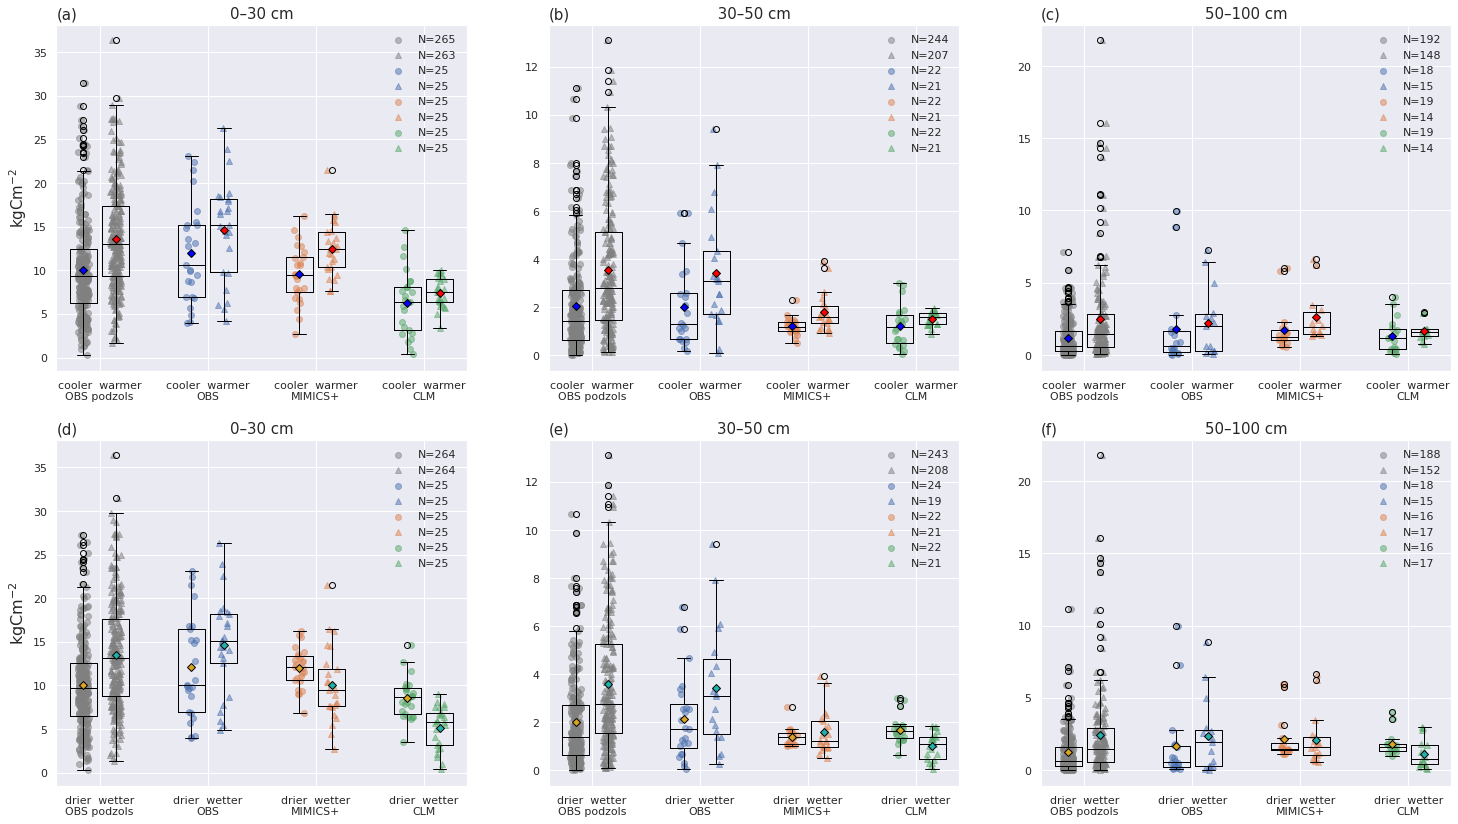

In [41]:
#Distributions where sites are removed from OBS distributions AND modeled distributions if stock is zero for OBS

#Wetter and drier: 
w30 = [podz_wo_subset.query("MAP_cat=='wetter'")[podz_wo_subset.stock30 > 0].stock30, obs_subset.query("MAP_cat=='wetter'").stock30,decomp_df.query("MAP_cat=='wetter'").stock30,CLM_df.query("MAP_cat=='wetter'").stock30]
d30 = [podz_wo_subset.query("MAP_cat=='drier'")[podz_wo_subset.stock30 > 0].stock30, obs_subset.query("MAP_cat=='drier'").stock30,decomp_df.query("MAP_cat=='drier'").stock30,CLM_df.query("MAP_cat=='drier'").stock30]

w30_50 = [podz_wo_subset.query("MAP_cat=='wetter'")[podz_wo_subset.stock30_50 > 0].stock30_50,
          obs_subset.query("MAP_cat=='wetter'")[obs_subset.stock30_50 > 0].stock30_50,
          decomp_df.query("MAP_cat=='wetter'")[obs_subset.stock30_50 > 0].stock30_50,
          CLM_df.query("MAP_cat=='wetter'")[obs_subset.stock30_50 > 0].stock30_50]

d30_50 = [podz_wo_subset.query("MAP_cat=='drier'")[podz_wo_subset.stock30_50 > 0].stock30_50, 
          obs_subset.query("MAP_cat=='drier'")[obs_subset.stock30_50 > 0].stock30_50,
          decomp_df.query("MAP_cat=='drier'")[obs_subset.stock30_50 > 0].stock30_50,
          CLM_df.query("MAP_cat=='drier'")[obs_subset.stock30_50 > 0].stock30_50]

w50_100 = [podz_wo_subset.query("MAP_cat=='wetter'")[podz_wo_subset.stock50_100 > 0].stock50_100, 
           obs_subset.query("MAP_cat=='wetter'")[obs_subset.stock50_100 > 0].stock50_100,
           decomp_df.query("MAP_cat=='wetter'")[obs_subset.stock50_100 > 0].stock50_100,
           CLM_df.query("MAP_cat=='wetter'")[obs_subset.stock50_100 > 0].stock50_100]
d50_100 = [podz_wo_subset.query("MAP_cat=='drier'")[podz_wo_subset.stock50_100 > 0].stock50_100,
           obs_subset.query("MAP_cat=='drier'")[obs_subset.stock50_100 > 0].stock50_100,
           decomp_df.query("MAP_cat=='drier'")[obs_subset.stock50_100 > 0].stock50_100,
           CLM_df.query("MAP_cat=='drier'")[obs_subset.stock50_100 > 0].stock50_100]

c30 = [podz_wo_subset.query("MAT_cat=='cooler'")[podz_wo_subset.stock30 > 0].stock30, obs_subset.query("MAT_cat=='cooler'").stock30,decomp_df.query("MAT_cat=='cooler'").stock30,CLM_df.query("MAT_cat=='cooler'").stock30]
wa30 = [podz_wo_subset.query("MAT_cat=='warmer'")[podz_wo_subset.stock30 > 0].stock30, obs_subset.query("MAT_cat=='warmer'").stock30,decomp_df.query("MAT_cat=='warmer'").stock30,CLM_df.query("MAT_cat=='warmer'").stock30]

        
c30_50 = [podz_wo_subset.query("MAT_cat=='cooler'")[podz_wo_subset.stock30_50 > 0].stock30_50 ,
          obs_subset.query("MAT_cat=='cooler'")[obs_subset.stock30_50 > 0].stock30_50,
          decomp_df.query("MAT_cat=='cooler'")[obs_subset.stock30_50 > 0].stock30_50,
          CLM_df.query("MAT_cat=='cooler'")[obs_subset.stock30_50 > 0].stock30_50]
          
wa30_50 = [podz_wo_subset.query("MAT_cat=='warmer'")[podz_wo_subset.stock30_50 > 0].stock30_50 ,
           obs_subset.query("MAT_cat=='warmer'")[obs_subset.stock30_50 > 0].stock30_50,
           decomp_df.query("MAT_cat=='warmer'")[obs_subset.stock30_50 > 0].stock30_50,
           CLM_df.query("MAT_cat=='warmer'")[obs_subset.stock30_50 > 0].stock30_50]

c50_100 = [podz_wo_subset.query("MAT_cat=='cooler'")[podz_wo_subset.stock50_100 > 0].stock50_100,
           obs_subset.query("MAT_cat=='cooler'")[obs_subset.stock50_100 > 0].stock50_100,
           decomp_df.query("MAT_cat=='cooler'")[obs_subset.stock50_100 > 0].stock50_100,
           CLM_df.query("MAT_cat=='cooler'")[obs_subset.stock50_100 > 0].stock50_100]
wa50_100 = [podz_wo_subset.query("MAT_cat=='warmer'")[podz_wo_subset.stock50_100 > 0].stock50_100,
            obs_subset.query("MAT_cat=='warmer'")[obs_subset.stock50_100 > 0].stock50_100,
            decomp_df.query("MAT_cat=='warmer'")[obs_subset.stock50_100 > 0].stock50_100,
            CLM_df.query("MAT_cat=='warmer'")[obs_subset.stock50_100 > 0].stock50_100]

font_dict={"fontsize":"x-large","fontweight":"bold"}
labels_1stline_MAP=["drier  wetter","drier  wetter","drier  wetter","drier  wetter"]
labels_1stline_MAT=["cooler  warmer","cooler  warmer","cooler  warmer","cooler  warmer"]
labels_2ndline=["\nOBS podzols","\nOBS","\nMIMICS+","\nCLM"]
positions1=[.5,2.5,4.5,6.5]
positions2=[1.1,3.1,5.1,7.1]
ticks_pos=[0.8,2.8,4.8,6.8,0.8,2.8,4.8,6.8]

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(25, 14))

ax1.boxplot(c30,positions=positions1,labels = labels_1stline_MAT,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":temp_colors[0],"markeredgecolor":"black"});
ax1.boxplot(wa30,positions=positions2,labels = labels_2ndline,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":temp_colors[1],"markeredgecolor":"black"});
ax1.set_title("(a)",fontsize = 15, loc = "left");
ax1.set_title("0–30 cm",fontsize = 15, loc = "center");
ax1.set_ylabel("$\mathrm{kgC m^{-2}}$",fontsize=15);
ax1.set_xticks(ticks_pos);
ax1.scatter(x=[positions1[0]+random.uniform(-0.1, 0.1) for i in range(len(c30[0]))],y=c30[0], label = "N=%i"%len(c30[0]),color="gray",alpha=0.5)
ax1.scatter(x=[positions2[0]+random.uniform(-0.1, 0.1) for i in range(len(wa30[0]))],y=wa30[0], label = "N=%i"%len(wa30[0]),color="gray",alpha=0.5,marker='^')
ax1.scatter(x=[positions1[1]+random.uniform(-0.1, 0.1) for i in range(len(c30[1]))],y=c30[1], label = "N=%i"%len(c30[1]),color=colors[0],alpha=0.5)
ax1.scatter(x=[positions2[1]+random.uniform(-0.1, 0.1) for i in range(len(wa30[1]))],y=wa30[1], label = "N=%i"%len(wa30[1]),color=colors[0],alpha=0.5,marker='^')
ax1.scatter(x=[positions1[2]+random.uniform(-0.1, 0.1) for i in range(len(c30[2]))],y=c30[2], label = "N=%i"%len(c30[2]),color=colors[1],alpha=0.5)
ax1.scatter(x=[positions2[2]+random.uniform(-0.1, 0.1) for i in range(len(wa30[2]))],y=wa30[2], label = "N=%i"%len(wa30[2]),color=colors[1],alpha=0.5,marker='^')
ax1.scatter(x=[positions1[3]+random.uniform(-0.1, 0.1) for i in range(len(c30[3]))],y=c30[3], label = "N=%i"%len(c30[3]),color=colors[2],alpha=0.5)
ax1.scatter(x=[positions2[3]+random.uniform(-0.1, 0.1) for i in range(len(wa30[3]))],y=wa30[3], label = "N=%i"%len(wa30[3]),color=colors[2],alpha=0.5,marker='^')
ax1.legend()

ax2.boxplot(c30_50,positions=positions1,labels = labels_1stline_MAT,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":temp_colors[0],"markeredgecolor":"black"});
ax2.boxplot(wa30_50,positions=positions2,labels = labels_2ndline,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":temp_colors[1],"markeredgecolor":"black"});
ax2.set_title("(b)", fontsize = 15, loc = "left")
ax2.set_title(" 30–50 cm ", fontsize = 15, loc = "center")
ax2.set_xticks(ticks_pos);
ax2.scatter(x=[positions1[0]+random.uniform(-0.1, 0.1) for i in range(len(c30_50[0]))],y=c30_50[0], label = "N=%i"%len(c30_50[0]),color="gray",alpha=0.5)
ax2.scatter(x=[positions2[0]+random.uniform(-0.1, 0.1) for i in range(len(wa30_50[0]))],y=wa30_50[0], label = "N=%i"%len(wa30_50[0]),color="gray",alpha=0.5,marker='^')
ax2.scatter(x=[positions1[1]+random.uniform(-0.1, 0.1) for i in range(len(c30_50[1]))],y=c30_50[1], label = "N=%i"%len(c30_50[1]),color=colors[0],alpha=0.5)
ax2.scatter(x=[positions2[1]+random.uniform(-0.1, 0.1) for i in range(len(wa30_50[1]))],y=wa30_50[1], label = "N=%i"%len(wa30_50[1]),color=colors[0],alpha=0.5,marker='^')
ax2.scatter(x=[positions1[2]+random.uniform(-0.1, 0.1) for i in range(len(c30_50[2]))],y=c30_50[2], label = "N=%i"%len(c30_50[2]),color=colors[1],alpha=0.5)
ax2.scatter(x=[positions2[2]+random.uniform(-0.1, 0.1) for i in range(len(wa30_50[2]))],y=wa30_50[2], label = "N=%i"%len(wa30_50[2]),color=colors[1],alpha=0.5,marker='^')
ax2.scatter(x=[positions1[3]+random.uniform(-0.1, 0.1) for i in range(len(c30_50[3]))],y=c30_50[3], label = "N=%i"%len(c30_50[3]),color=colors[2],alpha=0.5)
ax2.scatter(x=[positions2[3]+random.uniform(-0.1, 0.1) for i in range(len(wa30_50[3]))],y=wa30_50[3], label = "N=%i"%len(wa30_50[3]),color=colors[2],alpha=0.5,marker='^')
ax2.legend()

ax3.boxplot(c50_100,positions=positions1,vert=True,showmeans=True,labels = labels_1stline_MAT,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":temp_colors[0],"markeredgecolor":"black"});
ax3.boxplot(wa50_100,positions=positions2,vert=True,showmeans=True,labels = labels_2ndline,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":temp_colors[1],"markeredgecolor":"black"});
ax3.set_title("(c)",fontsize = 15, loc = "left");
ax3.set_title("50–100 cm",fontsize = 15, loc = "center");
ax3.set_xticks(ticks_pos);
ax3.scatter(x=[positions1[0]+random.uniform(-0.1, 0.1) for i in range(len(c50_100[0]))],y=c50_100[0], label = "N=%i"%len(c50_100[0]),color="gray",alpha=0.5)
ax3.scatter(x=[positions2[0]+random.uniform(-0.1, 0.1) for i in range(len(wa50_100[0]))],y=wa50_100[0], label = "N=%i"%len(wa50_100[0]),color="gray",alpha=0.5,marker='^')
ax3.scatter(x=[positions1[1]+random.uniform(-0.1, 0.1) for i in range(len(c50_100[1]))],y=c50_100[1], label = "N=%i"%len(c50_100[1]),color=colors[0],alpha=0.5)
ax3.scatter(x=[positions2[1]+random.uniform(-0.1, 0.1) for i in range(len(wa50_100[1]))],y=wa50_100[1], label = "N=%i"%len(wa50_100[1]),color=colors[0],alpha=0.5,marker='^')
ax3.scatter(x=[positions1[2]+random.uniform(-0.1, 0.1) for i in range(len(c50_100[2]))],y=c50_100[2], label = "N=%i"%len(c50_100[2]),color=colors[1],alpha=0.5)
ax3.scatter(x=[positions2[2]+random.uniform(-0.1, 0.1) for i in range(len(wa50_100[2]))],y=wa50_100[2], label = "N=%i"%len(wa50_100[2]),color=colors[1],alpha=0.5,marker='^')
ax3.scatter(x=[positions1[3]+random.uniform(-0.1, 0.1) for i in range(len(c50_100[3]))],y=c50_100[3], label = "N=%i"%len(c50_100[3]),color=colors[2],alpha=0.5)
ax3.scatter(x=[positions2[3]+random.uniform(-0.1, 0.1) for i in range(len(wa50_100[3]))],y=wa50_100[3], label = "N=%i"%len(wa50_100[3]),color=colors[2],alpha=0.5,marker='^')
ax3.legend()

ax4.boxplot(d30,positions=positions1,labels = labels_1stline_MAP,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":prec_colors[0],"markeredgecolor":"black"});
ax4.boxplot(w30,positions=positions2,labels = labels_2ndline,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":prec_colors[1],"markeredgecolor":"black"});
ax4.set_title("(d)",fontsize = 15, loc = "left");
ax4.set_title("0–30 cm",fontsize = 15, loc = "center");
ax4.set_ylabel("$\mathrm{kgC m^{-2}}$",fontsize=16);
ax4.set_xticks(ticks_pos);
ax4.scatter(x=[positions1[0]+random.uniform(-0.1, 0.1) for i in range(len(d30[0]))],y=d30[0], label = "N=%i"%len(d30[0]),color="gray",alpha=0.5)
ax4.scatter(x=[positions2[0]+random.uniform(-0.1, 0.1) for i in range(len(w30[0]))],y=w30[0], label = "N=%i"%len(w30[0]),color="gray",alpha=0.5,marker='^')
ax4.scatter(x=[positions1[1]+random.uniform(-0.1, 0.1) for i in range(len(d30[1]))],y=d30[1], label = "N=%i"%len(d30[1]),color=colors[0],alpha=0.5)
ax4.scatter(x=[positions2[1]+random.uniform(-0.1, 0.1) for i in range(len(w30[1]))],y=w30[1], label = "N=%i"%len(w30[1]),color=colors[0],alpha=0.5,marker='^')
ax4.scatter(x=[positions1[2]+random.uniform(-0.1, 0.1) for i in range(len(d30[2]))],y=d30[2], label = "N=%i"%len(d30[2]),color=colors[1],alpha=0.5)
ax4.scatter(x=[positions2[2]+random.uniform(-0.1, 0.1) for i in range(len(w30[2]))],y=w30[2], label = "N=%i"%len(w30[2]),color=colors[1],alpha=0.5,marker='^')
ax4.scatter(x=[positions1[3]+random.uniform(-0.1, 0.1) for i in range(len(d30[3]))],y=d30[3], label = "N=%i"%len(d30[3]),color=colors[2],alpha=0.5)
ax4.scatter(x=[positions2[3]+random.uniform(-0.1, 0.1) for i in range(len(w30[3]))],y=w30[3], label = "N=%i"%len(w30[3]),color=colors[2],alpha=0.5,marker='^')
ax4.legend()

ax5.boxplot(d30_50,positions=positions1,labels = labels_1stline_MAP,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":prec_colors[0],"markeredgecolor":"black"});
ax5.boxplot(w30_50,positions=positions2,labels =labels_2ndline,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":prec_colors[1],"markeredgecolor":"black"});
ax5.set_title("(e)",fontsize = 15, loc = "left");
ax5.set_title("30–50 cm",fontsize = 15, loc = "center");
ax5.set_xticks(ticks_pos);
ax5.scatter(x=[positions1[0]+random.uniform(-0.1, 0.1) for i in range(len(d30_50[0]))],y=d30_50[0], label = "N=%i"%len(d30_50[0]),color="gray",alpha=0.5)
ax5.scatter(x=[positions2[0]+random.uniform(-0.1, 0.1) for i in range(len(w30_50[0]))],y=w30_50[0], label = "N=%i"%len(w30_50[0]),color="gray",alpha=0.5,marker='^')
ax5.scatter(x=[positions1[1]+random.uniform(-0.1, 0.1) for i in range(len(d30_50[1]))],y=d30_50[1], label = "N=%i"%len(d30_50[1]),color=colors[0],alpha=0.5)
ax5.scatter(x=[positions2[1]+random.uniform(-0.1, 0.1) for i in range(len(w30_50[1]))],y=w30_50[1], label = "N=%i"%len(w30_50[1]),color=colors[0],alpha=0.5,marker='^')
ax5.scatter(x=[positions1[2]+random.uniform(-0.1, 0.1) for i in range(len(d30_50[2]))],y=d30_50[2], label = "N=%i"%len(d30_50[2]),color=colors[1],alpha=0.5)
ax5.scatter(x=[positions2[2]+random.uniform(-0.1, 0.1) for i in range(len(w30_50[2]))],y=w30_50[2], label = "N=%i"%len(w30_50[2]),color=colors[1],alpha=0.5,marker='^')
ax5.scatter(x=[positions1[3]+random.uniform(-0.1, 0.1) for i in range(len(d30_50[3]))],y=d30_50[3], label = "N=%i"%len(d30_50[3]),color=colors[2],alpha=0.5)
ax5.scatter(x=[positions2[3]+random.uniform(-0.1, 0.1) for i in range(len(w30_50[3]))],y=w30_50[3], label = "N=%i"%len(w30_50[3]),color=colors[2],alpha=0.5,marker='^')
ax5.legend()

ax6.boxplot(d50_100,positions=positions1,labels = labels_1stline_MAP,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":prec_colors[0],"markeredgecolor":"black"});
ax6.boxplot(w50_100,positions=positions2,labels =labels_2ndline,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":prec_colors[1],"markeredgecolor":"black"});
ax6.set_title(r"$c)$"+"\t\t\t50-100 cm",fontsize = 15, loc = "left");
ax6.set_title(r"(f)",fontsize = 15, loc = "left");
ax6.set_title("50–100 cm",fontsize = 15, loc = "center");
ax6.set_xticks(ticks_pos);
ax6.scatter(x=[positions1[0]+random.uniform(-0.1, 0.1) for i in range(len(d50_100[0]))],y=d50_100[0], label = "N=%i"%len(d50_100[0]),color="gray",alpha=0.5)
ax6.scatter(x=[positions2[0]+random.uniform(-0.1, 0.1) for i in range(len(w50_100[0]))],y=w50_100[0], label = "N=%i"%len(w50_100[0]),color="gray",alpha=0.5,marker='^')
ax6.scatter(x=[positions1[1]+random.uniform(-0.1, 0.1) for i in range(len(d50_100[1]))],y=d50_100[1], label = "N=%i"%len(d50_100[1]),color=colors[0],alpha=0.5)
ax6.scatter(x=[positions2[1]+random.uniform(-0.1, 0.1) for i in range(len(w50_100[1]))],y=w50_100[1], label = "N=%i"%len(w50_100[1]),color=colors[0],alpha=0.5,marker='^')
ax6.scatter(x=[positions1[2]+random.uniform(-0.1, 0.1) for i in range(len(d50_100[2]))],y=d50_100[2], label = "N=%i"%len(d50_100[2]),color=colors[1],alpha=0.5)
ax6.scatter(x=[positions2[2]+random.uniform(-0.1, 0.1) for i in range(len(w50_100[2]))],y=w50_100[2], label = "N=%i"%len(w50_100[2]),color=colors[1],alpha=0.5,marker='^')
ax6.scatter(x=[positions1[3]+random.uniform(-0.1, 0.1) for i in range(len(d50_100[3]))],y=d50_100[3], label = "N=%i"%len(d50_100[3]),color=colors[2],alpha=0.5)
ax6.scatter(x=[positions2[3]+random.uniform(-0.1, 0.1) for i in range(len(w50_100[3]))],y=w50_100[3], label = "N=%i"%len(w50_100[3]),color=colors[2],alpha=0.5,marker='^')
ax6.legend()


#plt.savefig("./paper_figures/f06_include_podzols.pdf",bbox_inches="tight")


### f06 analysis

#### Difference between datasets, warmer and cooler:

In [42]:


print("....Significance tests comparing datasets: ....")
print("------0-30cm------------------")
print("-----------warmer-------------")
significance_ttest(wa30[0],"OBS podzols 0-30cm warmer", wa30[1],"OBS 0-30cm warmer",alpha=0.05,equal_var=False)
significance_ttest(wa30[0],"OBS podzols 0-30cm warmer", wa30[2],"MIMICS+ 0-30cm warmer",alpha=0.05,equal_var=False)
significance_ttest(wa30[0],"OBS podzols 0-30cm warmer", wa30[3],"CLM 0-30cm warmer",alpha=0.05,equal_var=False)
significance_ttest(wa30[1],"OBS 0-30cm warmer", wa30[2],"MIMICS+ 0-30cm warmer",alpha=0.05,equal_var=False)
significance_ttest(wa30[1],"OBS 0-30cm warmer", wa30[3],"CLM 0-30cm warmer",alpha=0.05,equal_var=False)
significance_ttest(wa30[3],"CLM 0-30cm warmer", wa30[2],"MIMICS+ 0-30cm warmer",alpha=0.05,equal_var=False)
print("-----------cooler-------------")
significance_ttest(c30[0],"OBS podzols 0-30cm cooler", c30[1],"OBS 0-30cm cooler",alpha=0.05,equal_var=False)
significance_ttest(c30[0],"OBS podzols 0-30cm cooler", c30[2],"MIMICS+ 0-30cm cooler",alpha=0.05,equal_var=False)
significance_ttest(c30[0],"OBS podzols 0-30cm cooler", c30[3],"CLM 0-30cm cooler",alpha=0.05,equal_var=False)
significance_ttest(c30[1],"OBS 0-30cm cooler", c30[2],"MIMICS+ 0-30cm cooler",alpha=0.05,equal_var=False)
significance_ttest(c30[1],"OBS 0-30cm cooler", c30[3],"CLM 0-30cm cooler",alpha=0.05,equal_var=False)
significance_ttest(c30[3],"CLM 0-30cm cooler", c30[2],"MIMICS+ 0-30cm cooler",alpha=0.05,equal_var=False)

print("------30-50cm------------------")
print("-----------warmer-------------")
significance_ttest(wa30_50[0],"OBS podzols 30-50cm warmer", wa30_50[1],"OBS 30-50cm warmer",alpha=0.05,equal_var=False)
significance_ttest(wa30_50[0],"OBS podzols 30-50cm warmer", wa30_50[2],"MIMICS+ 30-50cm warmer",alpha=0.05,equal_var=False)
significance_ttest(wa30_50[0],"OBS podzols 30-50cm warmer", wa30_50[3],"CLM 30-50cm warmer",alpha=0.05,equal_var=False)
significance_ttest(wa30_50[1],"OBS 30-50cm warmer", wa30_50[2],"MIMICS+ 30-50cm warmer",alpha=0.05,equal_var=False)
significance_ttest(wa30_50[1],"OBS 30-50cm warmer", wa30_50[3],"CLM 30-50cm warmer",alpha=0.05,equal_var=False)
significance_ttest(wa30_50[3],"CLM 30-50cm warmer", wa30_50[2],"MIMICS+ 30-50cm warmer",alpha=0.05,equal_var=False)
print("-----------cooler-------------")
significance_ttest(c30_50[0],"OBS podzols 30-50cm cooler", c30_50[1],"OBS 30-50cm cooler",alpha=0.05,equal_var=False)
significance_ttest(c30_50[0],"OBS podzols 30-50cm cooler", c30_50[2],"MIMICS+ 30-50cm cooler",alpha=0.05,equal_var=False)
significance_ttest(c30_50[0],"OBS podzols 30-50cm cooler", c30_50[3],"CLM 30-50cm cooler",alpha=0.05,equal_var=False)
significance_ttest(c30_50[1],"OBS 30-50cm cooler", c30_50[2],"MIMICS+ 30-50cm cooler",alpha=0.05,equal_var=False)
significance_ttest(c30_50[1],"OBS 30-50cm cooler", c30_50[3],"CLM 30-50cm cooler",alpha=0.05,equal_var=False)
significance_ttest(c30_50[3],"CLM 30-50cm cooler", c30_50[2],"MIMICS+ 30-50cm cooler",alpha=0.05,equal_var=False)

print("------50-100cm------------------")
print("-----------warmer-------------")
significance_ttest(wa50_100[0],"OBS podzols 50-100 warmer", wa50_100[1],"OBS 50-100 warmer",alpha=0.05,equal_var=False)
significance_ttest(wa50_100[0],"OBS podzols 50-100 warmer", wa50_100[2],"MIMICS+ 50-100 warmer",alpha=0.05,equal_var=False)
significance_ttest(wa50_100[0],"OBS podzols 50-100 warmer", wa50_100[3],"CLM 50-100 warmer",alpha=0.05,equal_var=False)
significance_ttest(wa50_100[1],"OBS 50-100 warmer", wa50_100[2],"MIMICS+ 50-100 warmer",alpha=0.05,equal_var=False)
significance_ttest(wa50_100[1],"OBS 50-100 warmer", wa50_100[3],"CLM 50-100 warmer",alpha=0.05,equal_var=False)
significance_ttest(wa50_100[3],"CLM 50-100 warmer", wa50_100[2],"MIMICS+ 50-100 warmer",alpha=0.05,equal_var=False)
print("-----------cooler-------------")
significance_ttest(c50_100[0],"OBS podzols 50-100 cooler", c50_100[1],"OBS 50-100 cooler",alpha=0.05,equal_var=False)
significance_ttest(c50_100[0],"OBS podzols 50-100 cooler", c50_100[2],"MIMICS+ 50-100 cooler",alpha=0.05,equal_var=False)
significance_ttest(c50_100[0],"OBS podzols 50-100 cooler", c50_100[3],"CLM 50-100 cooler",alpha=0.05,equal_var=False)
significance_ttest(c50_100[1],"OBS 50-100 cooler", c50_100[2],"MIMICS+ 50-100 cooler",alpha=0.05,equal_var=False)
significance_ttest(c50_100[1],"OBS 50-100 cooler", c50_100[3],"CLM 50-100 cooler",alpha=0.05,equal_var=False)
significance_ttest(c50_100[3],"CLM 50-100 cooler", c50_100[2],"MIMICS+ 50-100 cooler",alpha=0.05,equal_var=False)

....Significance tests comparing datasets: ....
------0-30cm------------------
-----------warmer-------------
OBS podzols 0-30cm warmer IS NOT significantly different from OBS 0-30cm warmer with alpha = 0.050
t-statistic = -0.918 pvalue = 0.3663
OBS podzols 0-30cm warmer IS NOT significantly different from MIMICS+ 0-30cm warmer with alpha = 0.050
t-statistic =  1.465 pvalue = 0.1502
OBS podzols 0-30cm warmer IS significantly different from CLM 0-30cm warmer with alpha = 0.050
t-statistic = 12.264 pvalue = 0.0000
OBS 0-30cm warmer IS NOT significantly different from MIMICS+ 0-30cm warmer with alpha = 0.050
t-statistic =  1.652 pvalue = 0.1070
OBS 0-30cm warmer IS significantly different from CLM 0-30cm warmer with alpha = 0.050
t-statistic =  5.964 pvalue = 0.0000
CLM 0-30cm warmer IS significantly different from MIMICS+ 0-30cm warmer with alpha = 0.050
t-statistic = -7.012 pvalue = 0.0000
-----------cooler-------------
OBS podzols 0-30cm cooler IS NOT significantly different from OBS 0

#### Difference between datasets drier and wetter

In [43]:
print("....Significance tests comparing datasets: ....")
print("------0-30cm------------------")
print("-----------drier-------------")
mf.significance_ttest(d30[1],"OBS 0-30cm drier", d30[2],"MIMICS+ 0-30cm drier",alpha=0.05,equal_var=False)
mf.significance_ttest(d30[1],"OBS 0-30cm drier", d30[3],"CLM 0-30cm drier",alpha=0.05,equal_var=False)
mf.significance_ttest(d30[3],"CLM 0-30cm drier", d30[2],"MIMICS+ 0-30cm drier",alpha=0.05,equal_var=False)

mf.significance_ttest(d30[0],"OBS podzols 0-30cm drier", d30[2],"MIMICS+ 0-30cm drier",alpha=0.05,equal_var=False)
mf.significance_ttest(d30[0],"OBS podzols 0-30cm drier", d30[3],"CLM 0-30cm drier",alpha=0.05,equal_var=False)
mf.significance_ttest(d30[0],"OBS podzols 0-30cm drier", d30[1],"OBS 0-30cm drier",alpha=0.05,equal_var=False)

print("-----------wetter-------------")
mf.significance_ttest(w30[1],"OBS 0-30cm wetter", w30[2],"MIMICS+ 0-30cm wetter",alpha=0.05,equal_var=False)
mf.significance_ttest(w30[1],"OBS 0-30cm wetter", w30[3],"CLM 0-30cm wetter",alpha=0.05,equal_var=False)
mf.significance_ttest(w30[3],"CLM 0-30cm wetter", w30[2],"MIMICS+ 0-30cm wetter",alpha=0.05,equal_var=False)

mf.significance_ttest(w30[0],"OBS podzols 0-30cm drier", w30[2],"MIMICS+ 0-30cm drier",alpha=0.05,equal_var=False)
mf.significance_ttest(w30[0],"OBS podzols 0-30cm drier", w30[3],"CLM 0-30cm drier",alpha=0.05,equal_var=False)
mf.significance_ttest(w30[0],"OBS podzols 0-30cm drier", w30[1],"OBS 0-30cm drier",alpha=0.05,equal_var=False)

print("------30-50cm------------------")
print("-----------drier-------------")
mf.significance_ttest(d30_50[1],"OBS 30-50 drier", d30_50[2],"MIMICS+ 30-50 drier",alpha=0.05,equal_var=False)
mf.significance_ttest(d30_50[1],"OBS 30-50 drier", d30_50[3],"CLM 30-50 drier",alpha=0.05,equal_var=False)
mf.significance_ttest(d30_50[3],"CLM 30-50 drier", d30_50[2],"MIMICS+ 30-50 drier",alpha=0.05,equal_var=False)

mf.significance_ttest(d30_50[0],"OBS podzols 30-50 drier", d30_50[2],"MIMICS+ 30-50 drier",alpha=0.05,equal_var=False)
mf.significance_ttest(d30_50[0],"OBS podzols 30-50 drier", d30_50[3],"CLM 30-50 drier",alpha=0.05,equal_var=False)
mf.significance_ttest(d30_50[0],"OBS podzols 30-50 drier", d30_50[1],"OBS 30-50 drier",alpha=0.05,equal_var=False)

print("-----------wetter-------------")
mf.significance_ttest(w30_50[1],"OBS 30-50 wetter", w30_50[2],"MIMICS+ 30-50 wetter",alpha=0.05,equal_var=False)
mf.significance_ttest(w30_50[1],"OBS 30-50 wetter", w30_50[3],"CLM 30-50 wetter",alpha=0.05,equal_var=False)
mf.significance_ttest(w30_50[3],"CLM 30-50 wetter", w30_50[2],"MIMICS+ 30-50 wetter",alpha=0.05,equal_var=False)

mf.significance_ttest(w30_50[0],"OBS podzols 30-50 drier", w30_50[2],"MIMICS+ 30-50 drier",alpha=0.05,equal_var=False)
mf.significance_ttest(w30_50[0],"OBS podzols 30-50 drier", w30_50[3],"CLM 30-50 drier",alpha=0.05,equal_var=False)
mf.significance_ttest(w30_50[0],"OBS podzols 30-50 drier", w30_50[1],"OBS 30-50 drier",alpha=0.05,equal_var=False)

print("------50-100cm------------------")
print("-----------drier-------------")
mf.significance_ttest(d50_100[1],"OBS 50-100cm drier", d50_100[2],"MIMICS+ 50-100cm drier",alpha=0.05,equal_var=False)
mf.significance_ttest(d50_100[1],"OBS 50-100cm drier", d50_100[3],"CLM 50-100cm drier",alpha=0.05,equal_var=False)
mf.significance_ttest(d50_100[3],"CLM 50-100cm drier", d50_100[2],"MIMICS+ 50-100cm drier",alpha=0.05,equal_var=False)

mf.significance_ttest(d50_100[0],"OBS podzols 50-100cm drier", d50_100[2],"MIMICS+ 50-100cm drier",alpha=0.05,equal_var=False)
mf.significance_ttest(d50_100[0],"OBS podzols 50-100cm drier", d50_100[3],"CLM 50-100cm drier",alpha=0.05,equal_var=False)
mf.significance_ttest(d50_100[0],"OBS podzols 50-100cm drier", d50_100[1],"OBS 50-100cm drier",alpha=0.05,equal_var=False)

print("-----------wetter-------------")
mf.significance_ttest(w50_100[1],"OBS 50-100cm wetter", w50_100[2],"MIMICS+ 50-100cm wetter",alpha=0.05,equal_var=False)
mf.significance_ttest(w50_100[1],"OBS 50-100cm wetter", w50_100[3],"CLM 50-100cm wetter",alpha=0.05,equal_var=False)
mf.significance_ttest(w50_100[3],"CLM 50-100cm wetter", w50_100[2],"MIMICS+ 50-100cm wetter",alpha=0.05,equal_var=False)

mf.significance_ttest(w50_100[0],"OBS podzols 50-100cm drier", w50_100[2],"MIMICS+ 50-100cm drier",alpha=0.05,equal_var=False)
mf.significance_ttest(w50_100[0],"OBS podzols 50-100cm drier", w50_100[3],"CLM 50-100cm drier",alpha=0.05,equal_var=False)
mf.significance_ttest(w50_100[0],"OBS podzols 50-100cm drier", w50_100[1],"OBS 50-100cm drier",alpha=0.05,equal_var=False)


....Significance tests comparing datasets: ....
------0-30cm------------------
-----------drier-------------
OBS 0-30cm drier IS NOT significantly different from MIMICS+ 0-30cm drier with alpha = 0.050
t-statistic =  0.037 pvalue = 0.9710
OBS 0-30cm drier IS significantly different from CLM 0-30cm drier with alpha = 0.050
t-statistic =  2.755 pvalue = 0.0097
CLM 0-30cm drier IS significantly different from MIMICS+ 0-30cm drier with alpha = 0.050
t-statistic = -5.281 pvalue = 0.0000
OBS podzols 0-30cm drier IS significantly different from MIMICS+ 0-30cm drier with alpha = 0.050
t-statistic = -3.480 pvalue = 0.0010
OBS podzols 0-30cm drier IS significantly different from CLM 0-30cm drier with alpha = 0.050
t-statistic =  2.665 pvalue = 0.0103
OBS podzols 0-30cm drier IS NOT significantly different from OBS 0-30cm drier with alpha = 0.050
t-statistic = -1.627 pvalue = 0.1151
-----------wetter-------------
OBS 0-30cm wetter IS significantly different from MIMICS+ 0-30cm wetter with alpha =

#### Difference between drier/wetter and warmer/colder within a dataset

In [44]:
print("-----OBS podzols cooler/warmer: ------\n")
mf.significance_ttest(wa30[0],"OBS podzols 0-30cm warmer",c30[0], "OBS podzols 0-30cm cooler",alpha=0.05,equal_var=True)
mf.significance_ttest(wa30_50[0],"OBS podzols 30-50cm warmer",c30_50[0], "OBS podzols 30-50cm cooler",alpha=0.05,equal_var=True)
mf.significance_ttest(wa50_100[0],"OBS podzols 50-100cm warmer",c50_100[0], "OBS podzols 50-100cm cooler",alpha=0.05,equal_var=True)

print("-----OBS podzols drier/wetter: ------\n")
mf.significance_ttest(w30[0],"OBS podzols 0-30cm wetter",d30[0], "OBS podzols 0-30cm drier",alpha=0.05,equal_var=True)
mf.significance_ttest(w30_50[0],"OBS podzols 30-50cm wetter",d30_50[0], "OBS podzols 30-50cm drier",alpha=0.05,equal_var=True)
mf.significance_ttest(w50_100[0],"OBS podzols 50-100cm wetter",d50_100[0], "OBS podzols 50-100cm drier",alpha=0.05,equal_var=True)


print("-----OBS cooler/warmer: ------\n")
mf.significance_ttest(wa30[1],"OBS 0-30cm warmer",c30[1], "OBS 0-30cm cooler",alpha=0.05,equal_var=True)
mf.significance_ttest(wa30_50[1],"OBS 30-50cm warmer",c30_50[1], "OBS 30-50cm cooler",alpha=0.05,equal_var=True)
mf.significance_ttest(wa50_100[1],"OBS 50-100cm warmer",c50_100[1], "OBS 50-100cm cooler",alpha=0.05,equal_var=True)

print("-----OBS drier/wetter: ------\n")
mf.significance_ttest(w30[1],"OBS 0-30cm wetter",d30[1], "OBS 0-30cm drier",alpha=0.05,equal_var=True)
mf.significance_ttest(w30_50[1],"OBS 30-50cm wetter",d30_50[1], "OBS 30-50cm drier",alpha=0.05,equal_var=True)
mf.significance_ttest(w50_100[1],"OBS 50-100cm wetter",d50_100[1], "OBS 50-100cm drier",alpha=0.05,equal_var=True)

print("-----MIMICS+ cooler/warmer: ------\n")
mf.significance_ttest(wa30[2],"MIMICS+ 0-30cm warmer",c30[2], "MIMICS+ 0-30cm cooler",alpha=0.05,equal_var=True)
mf.significance_ttest(wa30_50[2],"MIMICS+ 30-50cm warmer",c30_50[2], "MIMICS+ 30-50cm cooler",alpha=0.05,equal_var=True)
mf.significance_ttest(wa50_100[2],"MIMICS+ 50-100cm warmer",c50_100[2], "MIMICS+ 50-100cm cooler",alpha=0.05,equal_var=True)

print("-----MIMICS+ drier/wetter: ------\n")
mf.significance_ttest(w30[2],"MIMICS+ 0-30cm wetter",d30[2], "MIMICS+ 0-30cm drier",alpha=0.05,equal_var=True)
mf.significance_ttest(w30_50[2],"MIMICS+ 30-50cm wetter",d30_50[2], "MIMICS+ 30-50cm drier",alpha=0.05,equal_var=True)
mf.significance_ttest(w50_100[2],"MIMICS+ 50-100cm wetter",d50_100[2], "MIMICS+ 50-100cm drier",alpha=0.05,equal_var=True)

print("-----CLM cooler/warmer: ------\n")
mf.significance_ttest(wa30[3],"CLM 0-30cm warmer",c30[3], "CLM 0-30cm cooler",alpha=0.05,equal_var=True)
mf.significance_ttest(wa30_50[3],"CLM 30-50cm warmer",c30_50[3], "CLM 30-50cm cooler",alpha=0.05,equal_var=True)
mf.significance_ttest(wa50_100[3],"CLM 50-100cm warmer",c50_100[3], "CLM 50-100cm cooler",alpha=0.05,equal_var=True)

print("-----CLM drier/wetter: ------\n")
mf.significance_ttest(w30[3],"CLM 0-30cm wetter",d30[3], "CLM 0-30cm drier",alpha=0.05,equal_var=True)
mf.significance_ttest(w30_50[3],"CLM 30-50cm wetter",d30_50[3], "CLM 30-50cm drier",alpha=0.05,equal_var=True)
mf.significance_ttest(w50_100[3],"CLM 50-100cm wetter",d50_100[3], "CLM 50-100cm drier",alpha=0.05,equal_var=True)

-----OBS podzols cooler/warmer: ------

OBS podzols 0-30cm warmer IS significantly different from OBS podzols 0-30cm cooler with alpha = 0.050
t-statistic =  6.952 pvalue = 0.0000
OBS podzols 30-50cm warmer IS significantly different from OBS podzols 30-50cm cooler with alpha = 0.050
t-statistic =  6.817 pvalue = 0.0000
OBS podzols 50-100cm warmer IS significantly different from OBS podzols 50-100cm cooler with alpha = 0.050
t-statistic =  4.945 pvalue = 0.0000
-----OBS podzols drier/wetter: ------

OBS podzols 0-30cm wetter IS significantly different from OBS podzols 0-30cm drier with alpha = 0.050
t-statistic =  6.926 pvalue = 0.0000
OBS podzols 30-50cm wetter IS significantly different from OBS podzols 30-50cm drier with alpha = 0.050
t-statistic =  7.139 pvalue = 0.0000
OBS podzols 50-100cm wetter IS significantly different from OBS podzols 50-100cm drier with alpha = 0.050
t-statistic =  4.499 pvalue = 0.0000
-----OBS cooler/warmer: ------

OBS 0-30cm warmer IS NOT significantly d

-----

#### fig:clim_profile_soil_water
Quartile plots using soil moisture instead of MAP as indicator of wet/dry conditions

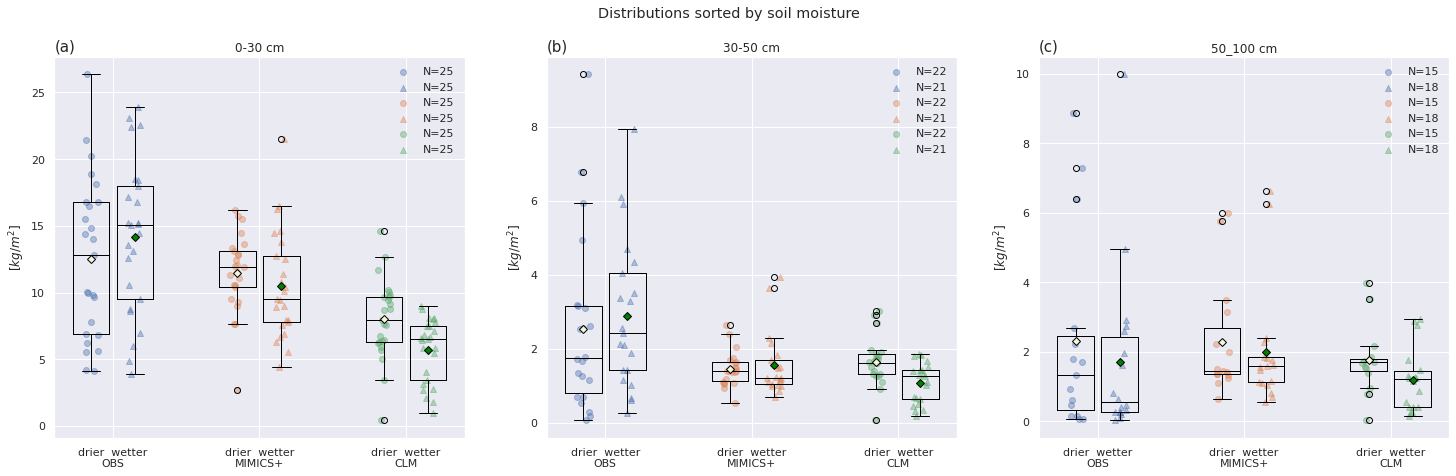

In [50]:
sns.set_style("darkgrid")
ws30 = [obs_subset.query("cat_SW=='wetter_soil'").stock30,decomp_df.query("cat_SW=='wetter_soil'").stock30,CLM_df.query("cat_SW=='wetter_soil'").stock30]
ds30 = [obs_subset.query("cat_SW=='drier_soil'").stock30,decomp_df.query("cat_SW=='drier_soil'").stock30,CLM_df.query("cat_SW=='drier_soil'").stock30]
ws30_50 = [obs_subset.query("cat_SW=='wetter_soil'")[obs_subset.stock30_50 > 0].stock30_50,
           decomp_df.query("cat_SW=='wetter_soil'")[obs_subset.stock30_50 > 0].stock30_50,
           CLM_df.query("cat_SW=='wetter_soil'")[obs_subset.stock30_50 > 0].stock30_50]
ds30_50 = [obs_subset.query("cat_SW=='drier_soil'")[obs_subset.stock30_50 > 0].stock30_50
           ,decomp_df.query("cat_SW=='drier_soil'")[obs_subset.stock30_50 > 0].stock30_50,CLM_df.query("cat_SW=='drier_soil'")[obs_subset.stock30_50 > 0].stock30_50]
ws50_100 = [obs_subset.query("cat_SW=='wetter_soil'")[obs_subset.stock50_100 > 0].stock50_100,
            decomp_df.query("cat_SW=='wetter_soil'")[obs_subset.stock50_100 > 0].stock50_100,
            CLM_df.query("cat_SW=='wetter_soil'")[obs_subset.stock50_100 > 0].stock50_100]
ds50_100 = [obs_subset.query("cat_SW=='drier_soil'")[obs_subset.stock50_100 > 0].stock50_100,
            decomp_df.query("cat_SW=='drier_soil'")[obs_subset.stock50_100 > 0].stock50_100,
            CLM_df.query("cat_SW=='drier_soil'")[obs_subset.stock50_100 > 0].stock50_100]
ticks_pos=[0.8,2.8,4.8,0.8,2.8,4.8]
labels_1stline_MAP=["drier  wetter","drier  wetter","drier  wetter"]
labels_1stline_MAT=["cooler  warmer","cooler  warmer","cooler  warmer"]
labels_2ndline=["\nOBS","\nMIMICS+","\nCLM"]
positions1=[.5,2.5,4.5]
positions2=[1.1,3.1,5.1]


font_dict={"fontsize":"x-large","fontweight":"bold"}
fig, ((ax1,ax2,ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(25, 7))
fig.suptitle("Distributions sorted by soil moisture")
ax1.boxplot(ds30,positions=positions1,labels = labels_1stline_MAP,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":"beige","markeredgecolor":"black"});
ax1.boxplot(ws30,positions=positions2,labels = labels_2ndline,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":"green","markeredgecolor":"black"});
ax1.set_title("0-30 cm");ax1.set_ylabel("[$kg/m^2$]");
#ax1.text(x=5,y=80,s="a)",fontdict=font_dict)
ax1.set_xticks(ticks_pos);
ax1.scatter(x=[positions1[0]+random.uniform(-0.1, 0.1) for i in range(len(ds30[0]))],y=ds30[0], label = "N=%i"%len(ds30[0]),color=colors[0],alpha=0.4)
ax1.scatter(x=[positions2[0]+random.uniform(-0.1, 0.1) for i in range(len(ws30[0]))],y=ws30[0], label = "N=%i"%len(ws30[0]),color=colors[0],alpha=0.4,marker='^')
ax1.scatter(x=[positions1[1]+random.uniform(-0.1, 0.1) for i in range(len(ds30[1]))],y=ds30[1], label = "N=%i"%len(ds30[1]),color=colors[1],alpha=0.4)
ax1.scatter(x=[positions2[1]+random.uniform(-0.1, 0.1) for i in range(len(ws30[1]))],y=ws30[1], label = "N=%i"%len(ws30[1]),color=colors[1],alpha=0.4,marker='^')
ax1.scatter(x=[positions1[2]+random.uniform(-0.1, 0.1) for i in range(len(ds30[2]))],y=ds30[2], label = "N=%i"%len(ds30[2]),color=colors[2],alpha=0.4)
ax1.scatter(x=[positions2[2]+random.uniform(-0.1, 0.1) for i in range(len(ws30[2]))],y=ws30[2], label = "N=%i"%len(ws30[2]),color=colors[2],alpha=0.4,marker='^')
ax1.legend()
ax1.set_title(r"(a)",fontsize = 15, loc = "left");

ax2.boxplot(ds30_50,positions=positions1,labels = labels_1stline_MAP,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":"beige","markeredgecolor":"black"});
ax2.boxplot(ws30_50,positions=positions2,labels = labels_2ndline,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":"green","markeredgecolor":"black"});
ax2.set_title("30-50 cm");ax2.set_ylabel("[$kg/m^2$]");
ax2.set_title(r"(b)",fontsize = 15, loc = "left");

#ax2.text(x=5,y=42,s="b)",fontdict=font_dict)
ax2.set_xticks(ticks_pos);
ax2.scatter(x=[positions1[0]+random.uniform(-0.1, 0.1) for i in range(len(ds30_50[0]))],y=ds30_50[0], label = "N=%i"%len(ds30_50[0]),color=colors[0],alpha=0.4)
ax2.scatter(x=[positions2[0]+random.uniform(-0.1, 0.1) for i in range(len(ws30_50[0]))],y=ws30_50[0], label = "N=%i"%len(ws30_50[0]),color=colors[0],alpha=0.4,marker='^')
ax2.scatter(x=[positions1[1]+random.uniform(-0.1, 0.1) for i in range(len(ds30_50[1]))],y=ds30_50[1], label = "N=%i"%len(ds30_50[1]),color=colors[1],alpha=0.4)
ax2.scatter(x=[positions2[1]+random.uniform(-0.1, 0.1) for i in range(len(ws30_50[1]))],y=ws30_50[1], label = "N=%i"%len(ws30_50[1]),color=colors[1],alpha=0.4,marker='^')
ax2.scatter(x=[positions1[2]+random.uniform(-0.1, 0.1) for i in range(len(ds30_50[2]))],y=ds30_50[2], label = "N=%i"%len(ds30_50[2]),color=colors[2],alpha=0.4)
ax2.scatter(x=[positions2[2]+random.uniform(-0.1, 0.1) for i in range(len(ws30_50[2]))],y=ws30_50[2], label = "N=%i"%len(ws30_50[2]),color=colors[2],alpha=0.4,marker='^')
ax2.legend()

ax3.boxplot(ds50_100,positions=positions1,labels = labels_1stline_MAP,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":"beige","markeredgecolor":"black"});
ax3.boxplot(ws50_100,positions=positions2,labels = labels_2ndline,vert=True,showmeans=True,
medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":"green","markeredgecolor":"black"});
ax3.set_ylabel("[$kg/m^2$]");ax3.set_title("50_100 cm");
ax3.set_title(r"(c)",fontsize = 15, loc = "left");

#ax3.text(x=5,y=18,s="c)",fontdict=font_dict)
ax3.set_xticks(ticks_pos);
ax3.scatter(x=[positions1[0]+random.uniform(-0.1, 0.1) for i in range(len(ds50_100[0]))],y=ds50_100[0], label = "N=%i"%len(ds50_100[0]),color=colors[0],alpha=0.4)
ax3.scatter(x=[positions2[0]+random.uniform(-0.1, 0.1) for i in range(len(ws50_100[0]))],y=ws50_100[0], label = "N=%i"%len(ws50_100[0]),color=colors[0],alpha=0.4,marker='^')
ax3.scatter(x=[positions1[1]+random.uniform(-0.1, 0.1) for i in range(len(ds50_100[1]))],y=ds50_100[1], label = "N=%i"%len(ds50_100[1]),color=colors[1],alpha=0.4)
ax3.scatter(x=[positions2[1]+random.uniform(-0.1, 0.1) for i in range(len(ws50_100[1]))],y=ws50_100[1], label = "N=%i"%len(ws50_100[1]),color=colors[1],alpha=0.4,marker='^')
ax3.scatter(x=[positions1[2]+random.uniform(-0.1, 0.1) for i in range(len(ds50_100[2]))],y=ds50_100[2], label = "N=%i"%len(ds50_100[2]),color=colors[2],alpha=0.4)
ax3.scatter(x=[positions2[2]+random.uniform(-0.1, 0.1) for i in range(len(ws50_100[2]))],y=ws50_100[2], label = "N=%i"%len(ws50_100[2]),color=colors[2],alpha=0.4,marker='^')
ax3.legend()
#plt.savefig("./paper_figures/climate_profile_soilwater.pdf",bbox_inches="tight")

#del ws30,ws30_50,ws50_100,ds30,ds30_50,ds50_100

In [51]:
mf.significance_ttest(ds30[0],"obs subset drier_soil 30cm",ws30[0], "obs subset wetter_soil, 30cm",alpha=0.050,equal_var=False)
mf.significance_ttest(ds30_50[0],"obs subset drier_soil 30_50cm",ws30_50[0], "obs subset wetter_soil, 30_50cm",alpha=0.050,equal_var=False)
mf.significance_ttest(ds50_100[0],"obs subset drier_soil 50_100cm",ws50_100[0], "obs subset wetter_soil, 50_100cm",alpha=0.050,equal_var=False)
print("----")
mf.significance_ttest(ds30[1],"MIMICS+ drier_soil 30cm",ws30[1], "MIMICS+ wetter_soil, 30cm",alpha=0.050,equal_var=False)
mf.significance_ttest(ds30_50[1],"MIMICS+ drier_soil 30_50cm",ws30_50[1], "MIMICS+ wetter_soil, 30_50cm",alpha=0.050,equal_var=False)
mf.significance_ttest(ds50_100[1],"MIMICS+ drier_soil 50_100cm",ws50_100[1], "MIMICS+ wetter_soil, 50_100cm",alpha=0.050,equal_var=False)

print("----")
mf.significance_ttest(ds30[2],"CLM drier_soil 30cm",ws30[2], "CLM wetter_soil, 30cm",alpha=0.050,equal_var=False)
mf.significance_ttest(ds30_50[2],"CLM drier_soil 30_50cm",ws30_50[2], "CLM wetter_soil, 30_50cm",alpha=0.050,equal_var=False)
mf.significance_ttest(ds50_100[2],"CLM drier_soil 50_100cm",ws50_100[2], "CLM wetter_soil, 50_100cm",alpha=0.050,equal_var=False)



obs subset drier_soil 30cm IS NOT significantly different from obs subset wetter_soil, 30cm with alpha = 0.050
t-statistic = -0.985 pvalue = 0.3296
obs subset drier_soil 30_50cm IS NOT significantly different from obs subset wetter_soil, 30_50cm with alpha = 0.050
t-statistic = -0.546 pvalue = 0.5884
obs subset drier_soil 50_100cm IS NOT significantly different from obs subset wetter_soil, 50_100cm with alpha = 0.050
t-statistic =  0.661 pvalue = 0.5140
----
MIMICS+ drier_soil 30cm IS NOT significantly different from MIMICS+ wetter_soil, 30cm with alpha = 0.050
t-statistic =  0.982 pvalue = 0.3312
MIMICS+ drier_soil 30_50cm IS NOT significantly different from MIMICS+ wetter_soil, 30_50cm with alpha = 0.050
t-statistic = -0.494 pvalue = 0.6249
MIMICS+ drier_soil 50_100cm IS NOT significantly different from MIMICS+ wetter_soil, 50_100cm with alpha = 0.050
t-statistic =  0.483 pvalue = 0.6329
----
CLM drier_soil 30cm IS significantly different from CLM wetter_soil, 30cm with alpha = 0.050

### Yearly input plots and tables

In [52]:
input_df = pd.DataFrame(columns = ["SITE","Litter input C","Litter input N","N deposition","C alloc to myc"])

for ds in decomp_data:
    #CARBON
    inp = ((ds.C_PlantLITm+ds.C_PlantLITs+ds.C_PlantSOMc+ds.C_PlantSOMp).T*depth[0:mf.no_of_layers(ds)]).sum("levsoi") #Sum mass input throughout column
    mean_input = (inp*24).groupby("time.year").sum()[:-1].mean() #[gC/m2h]*24 --> [gC/m2 day] input per day. Group values into separate years, summarize input in each year (skip 1993) and return the mean value of the 5 years

    inp_myc = ((ds.C_PlantEcM+ds.C_PlantAM).T*depth[0:mf.no_of_layers(ds)]).sum("levsoi") #Sum mass input throughout column
    mean_input_myc = (inp_myc*24).groupby("time.year").sum()[:-1].mean() #[gC/m2h]*24 --> [gC/m2] input per day. Group values into separate years, summarize input in each year (skip 1993) and return the mean value of the 5 years
    
    #NITROGEN
    inp_N = ((ds.N_PlantLITm+ds.N_PlantLITs+ds.N_PlantSOMc+ds.N_PlantSOMp).T*depth[0:mf.no_of_layers(ds)]).sum("levsoi")
    mean_input_N=(inp_N*24).groupby("time.year").sum()[:-1].mean()

    inp_Ndep = ((ds.N_Deposition).T*depth[0:mf.no_of_layers(ds)]).sum("levsoi")
    mean_input_Ndep=(inp_Ndep*24).groupby("time.year").sum()[:-1].mean()
    input_df.loc[len(input_df)]={"SITE":ds.site_name,"Litter input C":float(mean_input.values),"Litter input N":float(mean_input_N),"C alloc to myc":float(mean_input_myc),"N deposition": float(mean_input_Ndep)}
input_df

,SITE,Litter input C,Litter input N,N deposition,C alloc to myc
0,NR31461_Nittedal,437.167921,6.572880,0.691794,65.528678
1,NR31463_Hurdal,590.046227,6.614083,0.636445,78.736805
2,NR31464_Hurdal,588.319881,6.280771,0.613753,66.775335
3,NR31513_Nes,464.917957,4.504171,0.739060,63.592312
4,NR31519_Nissedal,583.867027,6.947359,0.854174,82.388475
5,NR31539_Modum,622.244287,6.447474,0.697217,46.351787
6,NR31577_Kvinesdal,581.038382,6.340645,0.932633,49.833388
7,NR31578_Kvinesdal,594.597248,6.552924,0.929145,50.971911
8,NR31579_Kvinesdal,641.533861,8.725603,0.925620,41.338358
9,NR31585_Flekkefjord,589.560452,6.249074,0.932562,39.828049


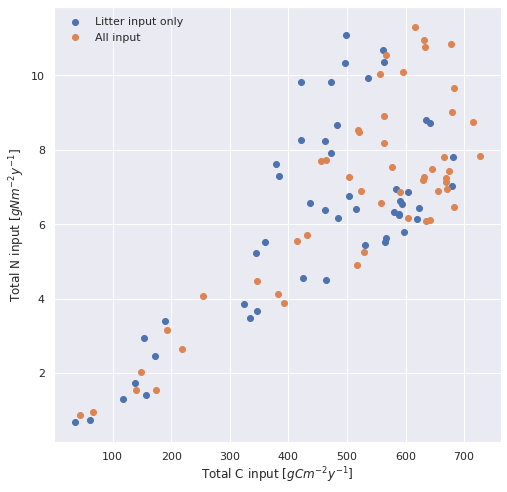

In [53]:
fig, ax = plt.subplots(figsize = [8,8])
plt.scatter(input_df["Litter input C"],input_df["Litter input N"],label = "Litter input only")
plt.scatter(input_df["Litter input C"]+input_df["C alloc to myc"],input_df["Litter input N"]+input_df["N deposition"],label="All input")
ax.set_xlabel("Total C input [$gC m^{-2} y^{-1}$]");ax.set_ylabel("Total N input [$gN m^{-2} y^{-1}$]")
ax.legend();
#fig.savefig("./paper_figures/input_distribution.pdf",bbox_inches="tight")


### fig:no_temp_dependence 

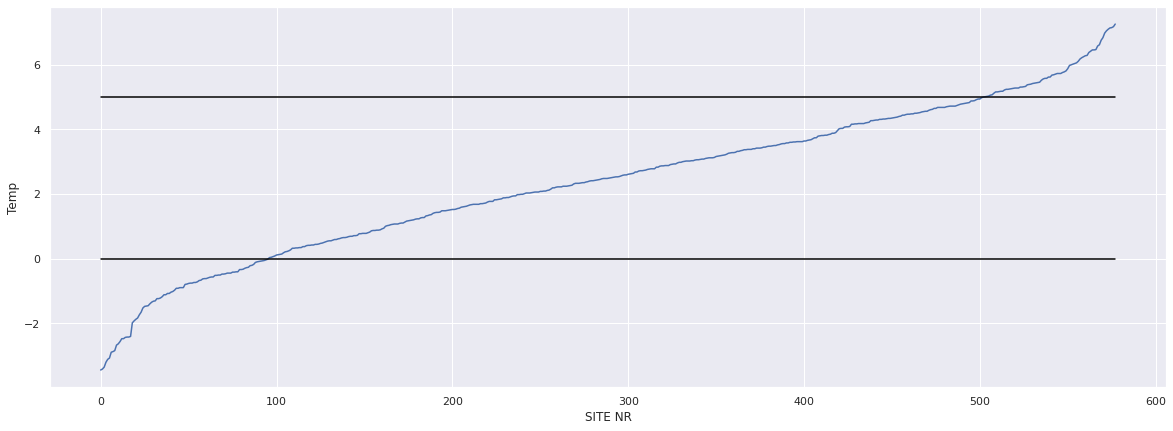

In [54]:
#Sites between the black lines are included in the analysis
plt.figure(figsize=[20,7])
(clean_pod.sort_values("MAT").reset_index()["MAT"]).plot();
plt.plot([i for i in range(578)],[0 for i in range(578)],color="black")
plt.plot([i for i in range(578)],[5 for i in range(578)],color="black")
plt.xlabel("SITE NR");plt.ylabel("Temp");

In [55]:
intervals = ["a","b","c","d","e","f","g","h","i","j"]
grouped_pod = clean_pod.groupby(pd.cut(clean_pod["MAT"], np.arange(0, 5.5, 0.5),labels=intervals))
grouped_pod.count()["MAT"]

MAT
a    32
b    35
c    36
d    42
e    50
f    41
g    53
h    35
i    45
j    38
Name: MAT, dtype: int64

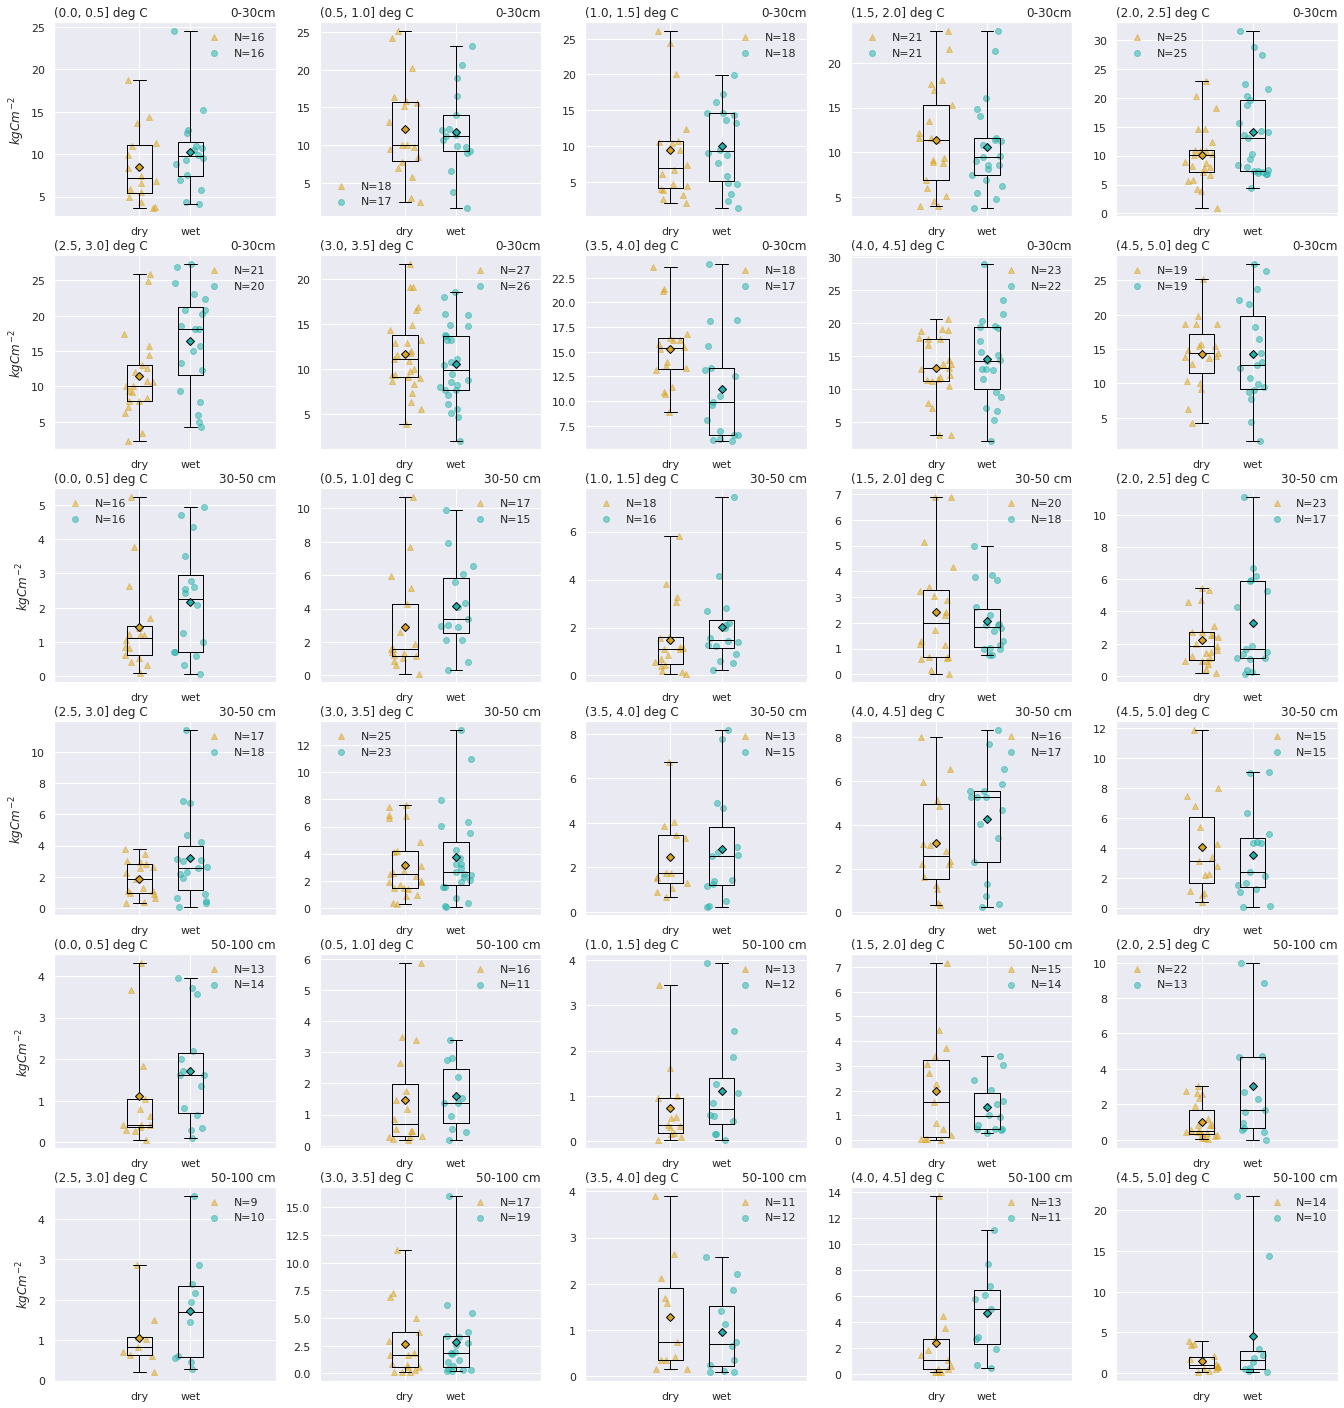

In [56]:

int = ["(0.0, 0.5]", "(0.5, 1.0]","(1.0, 1.5]","(1.5, 2.0]","(2.0, 2.5]","(2.5, 3.0]","(3.0, 3.5]","(3.5, 4.0]","(4.0, 4.5]","(4.5, 5.0]"]
fig, axes = plt.subplots(nrows=6,ncols=5,figsize=[23,25]);

axes = axes.ravel()
for i in range(10):
    df=grouped_pod.get_group(intervals[i])
    df_dry = df[df.MAP <= df.MAP.median()].stock30
    df_wet = df[df.MAP > df.MAP.median()].stock30
    axes[i].boxplot(df_dry,positions=[0.5],labels = ["dry"],vert=True,showmeans=True,
    medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":prec_colors[0],"markeredgecolor":"black"},whis=[0, 100]);
    axes[i].boxplot(df_wet,labels = ["wet"],vert=True,showmeans=True,
    medianprops={"color":"black"},positions=[0.8],meanprops={"marker":"D","markerfacecolor":prec_colors[1],"markeredgecolor":"black"},whis=[0, 100]);
    axes[i].set_title(int[i]+" deg C",fontsize = 12, loc = "left");
    axes[i].set_title("0-30cm",fontsize = 12, loc = "right");
    axes[i].scatter(x=[0.5+random.uniform(-0.1, 0.1) for i in range(len(df_dry))],y=df_dry,marker="^", label = "N=%i"%len(df_dry),color=prec_colors[0],alpha=0.5)
    axes[i].scatter(x=[0.8+random.uniform(-0.1, 0.1) for i in range(len(df_wet))],y=df_wet, label = "N=%i"%len(df_wet),color=prec_colors[1],alpha=0.5)
    axes[i].legend();

for i in range(10,20):
    df=grouped_pod.get_group(intervals[i-10])
    df_dry = df[df.MAP <= df.MAP.median()][df.stock30_50 > 0].stock30_50
    df_wet = df[df.MAP > df.MAP.median()][df.stock30_50 > 0].stock30_50
    axes[i].boxplot(df_dry,positions=[0.5],labels = ["dry"],vert=True,showmeans=True,
    medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":prec_colors[0],"markeredgecolor":"black"},whis=[0, 100]);
    axes[i].boxplot(df_wet,labels = ["wet"],vert=True,showmeans=True,
    medianprops={"color":"black"},positions=[0.8],meanprops={"marker":"D","markerfacecolor":prec_colors[1],"markeredgecolor":"black"},whis=[0, 100]);
    axes[i].set_title(int[i-10]+" deg C",fontsize = 12, loc = "left");
    axes[i].set_title("30-50 cm",fontsize = 12, loc = "right");
    # axes[i].set_xticks(ticks_pos);
    axes[i].scatter(x=[0.5+random.uniform(-0.1, 0.1) for i in range(len(df_dry))],y=df_dry,marker="^", label = "N=%i"%len(df_dry),color=prec_colors[0],alpha=0.5)
    axes[i].scatter(x=[0.8+random.uniform(-0.1, 0.1) for i in range(len(df_wet))],y=df_wet, label = "N=%i"%len(df_wet),color=prec_colors[1],alpha=0.5)
    axes[i].legend();


for i in range(20,30):
    df=grouped_pod.get_group(intervals[i-20])
    df_dry = df[df.MAP <= df.MAP.median()][df.stock50_100 > 0].stock50_100
    df_wet = df[df.MAP > df.MAP.median()][df.stock50_100 > 0].stock50_100
    axes[i].boxplot(df_dry,positions=[0.5],labels = ["dry"],vert=True,showmeans=True,
    medianprops={"color":"black"},meanprops={"marker":"D","markerfacecolor":prec_colors[0],"markeredgecolor":"black"},whis=[0, 100]);
    axes[i].boxplot(df_wet,labels = ["wet"],vert=True,showmeans=True,
    medianprops={"color":"black"},positions=[0.8],meanprops={"marker":"D","markerfacecolor":prec_colors[1],"markeredgecolor":"black"},whis=[0, 100]);
    axes[i].set_title(int[i-20]+" deg C",fontsize = 12, loc = "left");
    axes[i].set_title("50-100 cm",fontsize = 12, loc = "right");
    # axes[i].set_xticks(ticks_pos);
    axes[i].scatter(x=[0.5+random.uniform(-0.1, 0.1) for i in range(len(df_dry))],y=df_dry,marker="^", label = "N=%i"%len(df_dry),color=prec_colors[0],alpha=0.5)
    axes[i].scatter(x=[0.8+random.uniform(-0.1, 0.1) for i in range(len(df_wet))],y=df_wet, label = "N=%i"%len(df_wet),color=prec_colors[1],alpha=0.5)
    axes[i].legend();

axes[0].set_ylabel("$kgCm^{-2}$")
axes[5].set_ylabel("$kgCm^{-2}$")
axes[10].set_ylabel("$kgCm^{-2}$")
axes[15].set_ylabel("$kgCm^{-2}$")
axes[20].set_ylabel("$kgCm^{-2}$")
axes[25].set_ylabel("$kgCm^{-2}$");
#fig.savefig("./paper_figures/no_temp_dependence.pdf",bbox_inches="tight")#

# Seasonal variation of microbial respiration

In [58]:
hr_in_months = 24*np.array([31,28,31,30,31,30,31,31,30,31,30,31])
sum_sites_mim =0
sum_sites_CLM =0
hr_df_mim = pd.DataFrame()
hr_df_CLM = pd.DataFrame()
for i in range(50):
    site = decomp_data[i].site_name
    month_mean = decomp_data[i].groupby("time.month").mean()
    month_total_rate = ((month_mean.HR_flux)*month_mean.layer_thickness).sum(axis = 1)*hr_in_months
    sum_sites_mim +=month_total_rate
    hr_df_mim[site] = month_total_rate
    CLM_month_mean = CLM_xarray[i].groupby("time.month").mean()
    CLMmonth_total_rate = (CLM_month_mean.HR*3600).sum(axis=1)*hr_in_months
    hr_df_CLM[site] = CLMmonth_total_rate
    sum_sites_CLM += CLMmonth_total_rate

mean_sites_mim = sum_sites_mim/len(decomp_data)
mean_sites_CLM =sum_sites_CLM/len(CLM_xarray)



Text(0, 0.5, 'HR [$gC\\cdot m^{-2}$]')

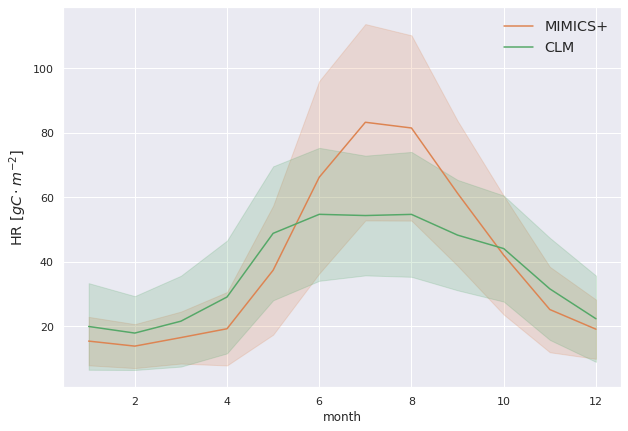

In [59]:
fig, ax = plt.subplots(figsize = [10,7])
mean_sites_mim.plot(label = "MIMICS+",color = colors[1])
mean_sites_CLM.plot(label = "CLM",color = colors[2])

ax.fill_between(mean_sites_mim.month, hr_df_mim.T.mean()-hr_df_mim.T.std(),hr_df_mim.T.mean()+hr_df_mim.T.std(),color = colors[1],alpha = 0.2)
ax.fill_between(mean_sites_CLM.month, hr_df_CLM.T.mean()-hr_df_CLM.T.std(),hr_df_CLM.T.mean()+hr_df_CLM.T.std(),color = colors[2],alpha = 0.2)
#ax.fill_between(var_df.T.columns,var_df.T.min(), var_df.T.max(),alpha=0.2,color="tab:blue")
ax.legend(fontsize = "large")
ax.set_ylabel("HR [$gC\cdot m^{-2}$]",fontsize = "large")
#plt.savefig("HR_seasonal_variation.pdf",bbox_inches="tight")